In order to connect to a kernel running on the server, and not loose the data if the connection gets closed (for instance the wifi shuts down) tap `server jupyter esistente` and than set the port on the server (7778) in order to be connected to a running jupyter notebook on the server. If it asks for a password it is the token of the notebook, which is `tokenA` and not the password of the account for authentication. 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import sys
import random
import functools
import pylab as plt

import math
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import gaussian_filter1d
import copy
import csv
import gc  #to free uneeded space in the server, otherwise for highest_mutation_neighborhood_robustness it takes all the RAM
from time import sleep
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
import concurrent.futures
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

In [2]:
cd research_projects/interattomi\ resilience

/home/PERSONALE/stefano.polizzi/research_projects/interattomi resilience


Here are all the functions for the removal of node in the interactome

In [ ]:
#Nicolas voleva fare la modified Shannon diversity del paper ma alla fine ha fatto quella modificata da Tommaso, perché rimuoveva dalla network i nodi selezionati via via, invece di rimuovere solo i link
#come fanno nel paper PNAS
##### RANDOM REMOVAL
def random_removal_robustness (graph, num_points = -1):
    network = copy.deepcopy(graph)
    
    
    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1
    
    if N > num_points-1 : num_rem = N//(num_points-1) #number of removed nodes. Must be an integer
    else: num_rem = 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0
    
    list_of_nodes = np.arange(0, N, 1).tolist()
    nodes_removed = random.sample(list_of_nodes, num_rem)

    for l in range( 1, num_points ):

        network.remove_nodes_from( nodes_removed )
        #print(network.number_of_nodes())  
        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ', P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]
        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + len(nodes_removed)/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

        list_of_nodes = list(network.nodes())
        nodes_removed = random.sample(list_of_nodes, num_rem) 
        #V(union)

    random_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return random_removal_dataframe




##### HIGHEST DEGREE REMOVAL
def highest_degree_robustness (graph, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer
    d = network.degree()

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]


    for l in range( 1, num_points ):

        d = sorted(d, key = take_second, reverse = True)

        max_deg_indices = 0
        for i in range(1, len(d)):
            if d[i][1] < d[i-1][1]: break
            max_deg_indices = i
        ind_max_degree = random.randint(0, max_deg_indices) #if several nodes of the same max degree choose randomly

        nodes_removed = d[ind_max_degree][0]

        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

        d = network.degree()

    hi_degree_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_degree_removal_dataframe

##### HIGHEST CLUSTERING COEFFICIENT REMOVAL
def highest_cc_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]


    for l in range( 1, num_points ):
        
        if (N - network.number_of_nodes()) < until :
            
            d = nx.clustering(network)
            d = sorted(d.items(), key=lambda item: item[1], reverse = True)

            max_deg_indices = 0
            for i in range(1, len(d)):
                if d[i][1] < d[i-1][1]: break
                max_deg_indices = i
            ind_max_cc = random.randint(0, max_deg_indices) #if several nodes of the same max cc choose randomly

            nodes_removed = d[ind_max_cc][0]
            
            
        else:
            list_of_nodes = list(network.nodes())
            nodes_removed = random.sample(list_of_nodes, num_rem)[0]

        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

       

        
        
    hi_cc_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_cc_removal_dataframe


##### HIGHEST CLUSTERING COEFFICIENT FIXED REMOVAL
def highest_cc_fixed_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]

    d = nx.clustering(network)
    d = sorted(d.items(), key=lambda item: item[1], reverse = True)

    for l in range( 1, num_points ):
        
        if (N - network.number_of_nodes()) < until :
            


            max_deg_indices = 0
            for i in range(1, len(d)):
                if d[i][1] < d[i-1][1]: break
                max_deg_indices = i
            ind_max_cc = random.randint(0, max_deg_indices) #if several nodes of the same max cc choose randomly

            nodes_removed = d[ind_max_cc][0]
            d.pop(ind_max_cc)[0]
          
            
        else:
            list_of_nodes = list(network.nodes())
            nodes_removed = random.sample(list_of_nodes, num_rem)[0]

        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

       

        
        
    hi_cc_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_cc_removal_dataframe


##### HIGHEST CC fixed + neighbors REMOVAL until a certain number of removed nodes. Then randomly
def highest_cc_fixed_neighbors_until_robustness (graph, num_points = -1, until = -1):
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]
    d = nx.clustering(network)
    d =  sorted(d.items(), key=lambda item: item[1], reverse = True)
    neighbors = []

    for l in range( 1, num_points ):
        
        if len(neighbors) == 0:
            if (N - network.number_of_nodes()) < until :

                max_cc_indices = 0
                for i in range(1, len(d)):
                    if d[i][1] < d[i-1][1]: break
                    max_cc_indices = i
                ind_max_cc = random.randint(0, max_cc_indices) #if several nodes of the same max cc choose randomly

                nodes_removed = d[ind_max_cc][0]                
                d.pop(ind_max_cc)[0]


            else:
                list_of_nodes = list(network.nodes())
                nodes_removed = random.sample(list_of_nodes, num_rem)[0]
                
            neighbors = list(network.neighbors(nodes_removed))
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)

        else:
            #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
            d = [item for item in d if item[0] != nodes_removed]
        
        #network.remove_edges_from(list(network.edges(nodes_removed))) #added to have the same measure of the PNAS
        network.remove_node( nodes_removed ) #commented to have the same measure of the PNAS      
        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]
        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp
        try:
            index = next((i for i, (first, second) in enumerate(d) if first == nodes_removed), None)
            if index!= None:
                d.pop(index)[0]        
        except ValueError:
            print(nodes_removed, "not found in d")  
        
    hi_cc_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    return hi_cc_removal_dataframe

##### HIGHEST DEGREE REMOVAL until a certain number of removed nodes. Then randomly
def highest_degree_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]


    for l in range( 1, num_points ):
        
        if (N - network.number_of_nodes()) < until :
            
            d = network.degree()
            d = sorted(d, key = take_second, reverse = True)

            max_deg_indices = 0
            for i in range(1, len(d)):
                if d[i][1] < d[i-1][1]: break
                max_deg_indices = i
            ind_max_degree = random.randint(0, max_deg_indices) #if several nodes of the same max degree choose randomly

            nodes_removed = d[ind_max_degree][0]
            
            
        else:
            list_of_nodes = list(network.nodes())
            nodes_removed = random.sample(list_of_nodes, num_rem)[0]

        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

       

        
        
    hi_degree_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_degree_removal_dataframe


##### HIGHEST DEGREE REMOVAL with the fixed initial degree sequence
def highest_degree_fixed_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]
    d = network.degree()
    d = sorted(d, key = take_second, reverse = True)

    for l in range( 1, num_points ):
        
        if (N - network.number_of_nodes()) < until :
            
            max_deg_indices = 0
            for i in range(1, len(d)):
                if d[i][1] < d[i-1][1]: break
                max_deg_indices = i
            ind_max_degree = random.randint(0, max_deg_indices) #if several nodes of the same max degree choose randomly

            nodes_removed = d[ind_max_degree][0]
            d.pop(ind_max_degree)[0]
            
        else:
            list_of_nodes = list(network.nodes())
            nodes_removed = random.sample(list_of_nodes, num_rem)[0]

        #network.remove_edges_from(list(network.edges(nodes_removed))) #added to have the same measure of the PNAS
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

       

        
        
    hi_degree_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_degree_removal_dataframe


##### HIGHEST DEGREE FIXED + NEIGHBORS REMOVAL until a certain number of removed nodes. Then randomly

def highest_degree_fixed_neighbors_until_robustness(graph, num_points = -1, until = -1):
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]
    d = network.degree()
    d = sorted(d, key = take_second, reverse = True)
    neighbors = []

    for l in range( 1, num_points ):
        
        if len(neighbors) == 0:
            if (N - network.number_of_nodes()) < until :
                max_deg_indices = 0
                for i in range(1, len(d)):
                    if d[i][1] < d[i-1][1]: break
                    max_deg_indices = i
                ind_max_degree = random.randint(0, max_deg_indices) #if several nodes of the same max degree choose randomly

                nodes_removed = d[ind_max_degree][0]
                d.pop(ind_max_degree)[0]

            else:
                list_of_nodes = list(network.nodes())
                nodes_removed = random.sample(list_of_nodes, num_rem)[0]
                
            neighbors = list(network.neighbors(nodes_removed))
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)

        else:
            #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
            d = [item for item in d if item[0] != nodes_removed]       
        network.remove_edges_from(list(network.edges(nodes_removed))) #added to have the same measure of the PNAS
        #network.remove_node( nodes_removed ) #commented to have the same measure of the PNAS
        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

        
    hi_degree_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_degree_removal_dataframe



##### HIGHEST DEGREE REMOVAL until a certain number of removed nodes. Then randomly
def highest_degree_neighbors_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]

    neighbors = []

    for l in range( 1, num_points ):
        
        if len(neighbors) == 0:
            if (N - network.number_of_nodes()) < until :

                d = network.degree()
                d = sorted(d, key = take_second, reverse = True)

                max_deg_indices = 0
                for i in range(1, len(d)):
                    if d[i][1] < d[i-1][1]: break
                    max_deg_indices = i
                ind_max_degree = random.randint(0, max_deg_indices) #if several nodes of the same max degree choose randomly

                nodes_removed = d[ind_max_degree][0]


            else:
                list_of_nodes = list(network.nodes())
                nodes_removed = random.sample(list_of_nodes, num_rem)[0]
                
            neighbors = list(network.neighbors(nodes_removed))
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)

        else:
            #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
        
        network.remove_edges_from(list(network.edges(nodes_removed))) #added to have the same measure of the PNAS
        #network.remove_node( nodes_removed ) #commented to have the same measure of the PNAS
        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

        
    hi_degree_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_degree_removal_dataframe


##### HIGHEST CLUSTERING COEFFICIENT REMOVAL and their neoghbors until a certain number of removed nodes. Then randomly
def highest_cc_neighbors_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]

    neighbors = []

    for l in range( 1, num_points ):
        if len(neighbors) == 0:
            if (N - network.number_of_nodes()) < until :
                d = nx.clustering(network)
                d =  sorted(d.items(), key=lambda item: item[1], reverse = True)
                max_cc_indices = 0
                for i in range(1, len(d)):
                    if d[i][1] < d[i-1][1]: break
                    max_cc_indices = i
                ind_max_cc = random.randint(0, max_cc_indices) #if several nodes of the same max cc choose randomly

                nodes_removed = d[ind_max_cc][0]                              
                d.pop(ind_max_cc)[0]


            else:
                list_of_nodes = list(network.nodes())
                nodes_removed = random.sample(list_of_nodes, num_rem)[0]
                
            neighbors = list(network.neighbors(nodes_removed))
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)

        else:
            #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
        
        #network.remove_edges_from(list(network.edges(nodes_removed))) #added to have the same measure of the PNAS
        network.remove_node( nodes_removed ) #commented to have the same measure of the PNAS      
        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]
        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp
        try:
            index = next((i for i, (first, second) in enumerate(d) if first == nodes_removed), None)
            if index!= None:
                d.pop(index)[0]        
        except ValueError:
            print(nodes_removed, "not found in d")  
        
    hi_cc_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_cc_removal_dataframe



##### HIGHEST BETWEENNESS COEFFICIENT REMOVAL and their neoghbors until a certain number of removed nodes. Then randomly
def highest_betweenness_neighbors_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]

    neighbors = []

    for l in range( 1, num_points ):
        if len(neighbors) == 0:
            if (N - network.number_of_nodes()) < until :
                d = nx.betweenness_centrality(network)
                d =  sorted(d.items(), key=lambda item: item[1], reverse = True)
                max_cc_indices = 0
                for i in range(1, len(d)):
                    if d[i][1] < d[i-1][1]: break
                    max_cc_indices = i
                ind_max_cc = random.randint(0, max_cc_indices) #if several nodes of the same max cc choose randomly

                nodes_removed = d[ind_max_cc][0]                              
                d.pop(ind_max_cc)[0]


            else:
                list_of_nodes = list(network.nodes())
                nodes_removed = random.sample(list_of_nodes, num_rem)[0]
                
            neighbors = list(network.neighbors(nodes_removed))
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)

        else:
            #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
        
        #network.remove_edges_from(list(network.edges(nodes_removed))) #added to have the same measure of the PNAS
        network.remove_node( nodes_removed ) #commented to have the same measure of the PNAS      
        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]
        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp
        try:
            index = next((i for i, (first, second) in enumerate(d) if first == nodes_removed), None)
            if index!= None:
                d.pop(index)[0]        
        except ValueError:
            print(nodes_removed, "not found in d")  
        
    hi_cc_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_cc_removal_dataframe


##### LOWEST DEGREE REMOVAL until a certain number of removed nodes. Then randomly
def lowest_degree_neighbors_until_robustness (graph, num_points = -1, until = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if until < 0 : until = N
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    #useful for the sorting algorithm
    def take_second(elem):
        return elem[1]

    neighbors = []

    for l in range( 1, num_points ):
        
        if len(neighbors) == 0:
            if (N - network.number_of_nodes()) < until :

                d = network.degree()
                d = sorted(d, key = take_second, reverse = False)

                max_deg_indices = 0
                for i in range(1, len(d)):
                    if d[i][1] > d[i-1][1]: break
                    max_deg_indices = i
                ind_max_degree = random.randint(0, max_deg_indices) #if several nodes of the same max degree choose randomly

                nodes_removed = d[ind_max_degree][0]


            else:
                list_of_nodes = list(network.nodes())
                nodes_removed = random.sample(list_of_nodes, num_rem)[0]
                
            neighbors = list(network.neighbors(nodes_removed))
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)

        else:
            #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 



        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly


        nodes_giant_comp = comp[ind_max_comp]

        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

        
    lo_degree_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return lo_degree_removal_dataframe

### HIGHEST MUTATION NODES REMOVAL
def highest_mutation_robustness (graph, mutation_map_filename, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    ### Variable mg generated by file tumor_mutations.R ###
    mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
    mg = mg.drop(0)
    mg['mutations'] = mg['mutations'].astype('float64') 

    mg_temp = copy.deepcopy(mg)
    N_mut = len(mg_temp)

    network_df = nx.to_pandas_edgelist(network)
    missing_gene_set = set(network_df['source']).union( set(network_df['target']) ) - set(mg['gene']) 
    mg_temp = pd.concat( [mg_temp, pd.DataFrame( { 'gene' : list( missing_gene_set ), 
                                                  'mutations' : [0]*len(missing_gene_set) } ) ], 
                       ignore_index = True)


    for l in range (1, num_points):

        if len(mg_temp) != 0:

            #Selection of one random node of the ones with maximum percentage
            nodes_removed = random.sample( list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]


            #if nodes_removed is not in the graph -> removes it and go on
            while (not (nodes_removed in network.nodes) ):

                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

                if len(mg_temp) == 0:
                    for i in range(l, len(P_inf)): P_inf[i] = P_inf[l-1]
                    for i in range(l, len(S)): S[i] = S[l-1]
                    for i in range(l, len(f)): f[i] = f[l-1]
                    nodes_removed = random.sample( list(network.nodes(), 1 ))[0]
                    break

                nodes_removed = random.sample( list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]
                
            
            mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )
                
        else:
            nodes_removed = random.sample( list(network.nodes(), 1 ))[0]
                                          
                                          
        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]
        
        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]


        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp


    hi_mutation_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_mutation_removal_dataframe


### REMOVING NODES WITH SAME DEGREE AS HIGHEST MUTATION NODES BUT SELECTED RANDOM AMONG NODES WITH THE SAME DEGREE
def highest_mutation_degree_robustness (graph, mutation_map_filename, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1
    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    ### Variable mg generated by file tumor_mutations.R ###
    mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
    mg = mg.drop(0)
    mg['mutations'] = mg['mutations'].astype('float64') 

    mg_temp = copy.deepcopy(mg)
    N_mut = len(mg_temp)

    network_df = nx.to_pandas_edgelist(network)
    missing_gene_set = set(network_df['source']).union( set(network_df['target']) ) - set(mg['gene']) 
    mg_temp = pd.concat( [mg_temp, pd.DataFrame( { 'gene' : list( missing_gene_set ), 
                                                  'mutations' : [0]*len(missing_gene_set) } ) ], 
                       ignore_index = True)


    for l in range (1, num_points):

        if len(mg_temp) != 0:

            #Selection of one random node of the ones with maximum percentage
            nodes_removed_mut = random.sample( list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]
            given_degree = network.degree(nodes_removed_mut)
            nodes_removed_temp = [node for node, degree in network.degree() if degree == given_degree]
            if len(nodes_removed_temp)!=0:
                nodes_removed = random.sample( list(nodes_removed_temp) ,1)[0]
            else:
                nodes_removed = nodes_removed_mut
            #if nodes_removed is not in the graph -> removes it and go on
            while (not (nodes_removed_mut in network.nodes) ):

                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed_mut ].index )

                if len(mg_temp) == 0:
                    for i in range(l, len(P_inf)): P_inf[i] = P_inf[l-1]
                    for i in range(l, len(S)): S[i] = S[l-1]
                    for i in range(l, len(f)): f[i] = f[l-1]
                    nodes_removed = random.sample( list(network.nodes(), 1 ))[0]
                    break

                nodes_removed_mut = random.sample( list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]
                given_degree = network.degree(nodes_removed_mut)
                nodes_removed_temp = [node for node, degree in network.degree() if degree == given_degree]
                if len(nodes_removed_temp)!=0:
                    nodes_removed = random.sample( list(nodes_removed_temp) ,1)[0]
                else:  
                    nodes_removed = nodes_removed_mut
            
            mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed_mut ].index )
                
        else:
            nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                                          
                                          
        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]
        
        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]


        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp


    hi_mutation_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_mutation_removal_dataframe

### Remove LOWEST mutated nodes and all their first neighbors

def lowest_mutation_neighborhood_robustness (graph , mutation_map_filename , num_points = -1):
    network = copy.deepcopy(graph)
    # initial number of nodes
    N = network.number_of_nodes()
    if num_points < 0 : num_points = N + 1
    f = np.arange (0, 1, 1/ num_points ).tolist()
    P_inf = np.arange (0, 1, 1/ num_points ).tolist()
    P_inf[0] = 1
    # entropy resilience
    S = np.arange (0, 1, 1/ num_points ).tolist()
    S[0] = 0
    num_rem = N//( num_points -1) # number of removed nodes . Must be an integer
    ### Variable mg generated by file tumor_mutations .R ###
    mg = pd.read_csv ( mutation_map_filename , delim_whitespace =True , names = ['gene', 'mutations'])
    mg = mg.drop (0)
    mg['mutations'] = mg['mutations'].astype('float64') 
    mg_temp = copy.copy (mg)
    N_mut = len( mg_temp )

    network_df = nx.to_pandas_edgelist( network )
    missing_gene_set = set( network_df ['source']).union( set(network_df ['target']) ) - set(mg['gene'])
    mg_temp = pd.concat( [ mg_temp , pd.DataFrame ( { 'gene' : list (missing_gene_set),'mutations' :[0]* len( missing_gene_set ) } ) ],
                             ignore_index = True )
    neighbors = []

    for l in range (1, num_points ):
    #IF THERE ARE NO MORE NEIGHBORS IT CHOOSE A NEW GENE FROM THE MG LIST
        if len( neighbors ) == 0:
            if len( mg_temp ) != 0:
            # Selection of one random node of the ones with minimum mutations
                nodes_removed = random.sample (list ( mg_temp.loc[ mg_temp ['mutations'] ==
                                mg_temp ['mutations'].min() ][ 'gene']) , 1) [0]
#if nodes_removed is not in the graph -> removes it and go on
                while (not ( nodes_removed in network.nodes ) ):
                    mg_temp = mg_temp.drop(mg_temp.loc[ mg_temp ['gene'] == nodes_removed].index )

                    if len( mg_temp ) == 0:
                        for i in range (l, len( P_inf )): P_inf [i] = P_inf [l -1]
                        for i in range (l, len(S)): S[i] = S[l -1]
                        for i in range (l, len(f)): f[i] = f[l -1]
                        nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                        break

                    nodes_removed = random.sample (list ( mg_temp.loc[ mg_temp ['mutations'] ==
                                mg_temp ['mutations'].min() ]['gene']) , 1) [0]
                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

            else:
                nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                # compute the neighbors of that node
            #print( nodes_removed in network.nodes )
            neighbors = list( network.neighbors( nodes_removed ) )
            if nodes_removed in neighbors :
                neighbors.remove( nodes_removed ) # Remove the node from the neighbours list if the chosen node is self - connected

        else : #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample( neighbors , 1) [0]
            neighbors.remove( nodes_removed )
        network.remove_node ( nodes_removed )
        
        comp = [c for c in sorted (nx.connected_components ( network ), key =len , reverse = True )]
        # BREAK if there are no more components
        if len( comp ) == 0:
            for i in range (l, len( P_inf )): P_inf [i] = 0
            for i in range (l, len(S)): S[i] = 0
            for i in range (l, len(f)): f[i] = f[l -1]
            print ('Final P_inf = ',P_inf [l])
            break

        max_indices = 0
        for i in range (1, len( comp )):
            if len( comp [i]) < len( comp [i -1]) : break
            max_indices = i
        
        ind_max_comp = random.randint(0, max_indices ) #if several components of the same max size choose randomly
        #nodes_giant_comp = comp [ ind_max_comp ]
        P_inf [l] = len( comp [ ind_max_comp ] )/N
        f[l] = f[l -1] + 1/N
        sum_comp = 0

        for k in range ( 0, len( comp ) ):
            p_i = len( comp [k] )/N
            sum_comp = sum_comp + p_i * math . log(p_i)
        S[l] = -1/math.log(N)*sum_comp
    del network
    del mg_temp
    gc.collect()        
    return pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})

### REMOVE HIGHEST MUTATED NODES AND ALL HIS FIRST NEiGHBORS.
def highest_mutation_neighborhood_robustness (graph , mutation_map_filename , num_points = -1):
    network = copy.deepcopy(graph)
    # initial number of nodes
    N = network.number_of_nodes()
    if num_points < 0 : num_points = N + 1
    f = np.arange (0, 1, 1/ num_points ).tolist()
    P_inf = np.arange (0, 1, 1/ num_points ).tolist()
    P_inf[0] = 1
    # entropy resilience
    S = np.arange (0, 1, 1/ num_points ).tolist()
    S[0] = 0
    num_rem = N//( num_points -1) # number of removed nodes . Must be an integer
    ### Variable mg generated by file tumor_mutations .R ###
    mg = pd.read_csv ( mutation_map_filename , delim_whitespace =True , names = ['gene', 'mutations'])
    mg = mg.drop (0)
    mg['mutations'] = mg['mutations'].astype('float64') 
    mg_temp = copy.copy (mg)
    N_mut = len( mg_temp )

    network_df = nx.to_pandas_edgelist( network )
    missing_gene_set = set( network_df ['source']).union( set(network_df ['target']) ) - set(mg['gene'])
    mg_temp = pd.concat( [ mg_temp , pd.DataFrame ( { 'gene' : list (missing_gene_set),'mutations' :[0]* len( missing_gene_set ) } ) ],
                             ignore_index = True )
    neighbors = []

    for l in range (1, num_points ):
    #IF THERE ARE NO MORE NEIGHBORS IT CHOOSE A NEW GENE FROM THE MG LIST
        if len( neighbors ) == 0:
            if len( mg_temp ) != 0:
            # Selection of one random node of the ones with maximum mutations
                nodes_removed = random.sample (list ( mg_temp.loc[ mg_temp ['mutations'] ==
                                mg_temp ['mutations'].max() ][ 'gene']) , 1) [0]
#if nodes_removed is not in the graph -> removes it and go on
                while (not ( nodes_removed in network.nodes ) ):
                    mg_temp = mg_temp.drop(mg_temp.loc[ mg_temp ['gene'] == nodes_removed].index )

                    if len( mg_temp ) == 0:
                        for i in range (l, len( P_inf )): P_inf [i] = P_inf [l -1]
                        for i in range (l, len(S)): S[i] = S[l -1]
                        for i in range (l, len(f)): f[i] = f[l -1]
                        nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                        break

                    nodes_removed = random.sample (list ( mg_temp.loc[ mg_temp ['mutations'] ==
                                mg_temp ['mutations'].max() ]['gene']) , 1) [0]
                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

            else:
                nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                # compute the neighbors of that node
            #print( nodes_removed in network.nodes )
            neighbors = list( network.neighbors( nodes_removed ) )
            if nodes_removed in neighbors :
                neighbors.remove( nodes_removed ) # Remove the node from the neighbours list if the chosen node is self - connected

        else : #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample( neighbors , 1) [0]
            neighbors.remove( nodes_removed )
        network.remove_node ( nodes_removed )
        
        comp = [c for c in sorted (nx.connected_components ( network ), key =len , reverse = True )]
        # BREAK if there are no more components
        if len( comp ) == 0:
            for i in range (l, len( P_inf )): P_inf [i] = 0
            for i in range (l, len(S)): S[i] = 0
            for i in range (l, len(f)): f[i] = f[l -1]
            print ('Final P_inf = ',P_inf [l])
            break

        max_indices = 0
        for i in range (1, len( comp )):
            if len( comp [i]) < len( comp [i -1]) : break
            max_indices = i
        
        ind_max_comp = random.randint(0, max_indices ) #if several components of the same max size choose randomly
        #nodes_giant_comp = comp [ ind_max_comp ]
        P_inf [l] = len( comp [ ind_max_comp ] )/N
        f[l] = f[l -1] + 1/N
        sum_comp = 0

        for k in range ( 0, len( comp ) ):
            p_i = len( comp [k] )/N
            sum_comp = sum_comp + p_i * math . log(p_i)
        S[l] = -1/math.log(N)*sum_comp
    del network
    del mg_temp
    gc.collect()        
    return pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})


### REMOVING NODES WITH SAME DEGREE AS HIGHEST MUTATION NODES AND THEIR NEIGHBORS BUT SELECTED RANDOM AMONG NODES WITH THE SAME DEGREE

def highest_mutation_degree_neighborhood_robustness (graph , mutation_map_filename , num_points = -1):
    network = copy.deepcopy(graph)
    # initial number of nodes
    N = network.number_of_nodes()
    if num_points < 0 : num_points = N + 1
    f = np.arange (0, 1, 1/ num_points ).tolist()
    P_inf = np.arange (0, 1, 1/ num_points ).tolist()
    P_inf[0] = 1
    # entropy resilience
    S = np.arange (0, 1, 1/ num_points ).tolist()
    S[0] = 0
    num_rem = N//( num_points -1) # number of removed nodes . Must be an integer
    ### Variable mg generated by file tumor_mutations .R ###
    mg = pd.read_csv ( mutation_map_filename , delim_whitespace =True , names = ['gene', 'mutations'])
    mg = mg.drop (0)
    mg['mutations'] = mg['mutations'].astype('float64') 
    mg_temp = copy.copy (mg)
    N_mut = len( mg_temp )

    network_df = nx.to_pandas_edgelist( network )
    missing_gene_set = set( network_df ['source']).union( set(network_df ['target']) ) - set(mg['gene'])
    mg_temp = pd.concat( [ mg_temp , pd.DataFrame ( { 'gene' : list (missing_gene_set),'mutations' :[0]* len( missing_gene_set ) } ) ],
                             ignore_index = True )
    neighbors = []

    for l in range (1, num_points ):
    #IF THERE ARE NO MORE NEIGHBORS IT CHOOSE A NEW GENE FROM THE MG LIST
        if len( neighbors ) == 0:
            if len( mg_temp ) != 0:
            # Selection of one random node of the ones with maximum mutations
                nodes_removed_mut = random.sample( list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]
                given_degree = network.degree(nodes_removed_mut)
                nodes_removed_temp = [node for node, degree in network.degree() if degree == given_degree]
                if len(nodes_removed_temp)!=0:
                    nodes_removed = random.sample( list(nodes_removed_temp) ,1)[0]
                else:
                    nodes_removed = nodes_removed_mut
#if nodes_removed is not in the graph -> removes it and go on
                while (not ( nodes_removed_mut in network.nodes ) ):
                    mg_temp = mg_temp.drop(mg_temp.loc[ mg_temp ['gene'] == nodes_removed_mut].index )

                    if len( mg_temp ) == 0:
                        for i in range (l, len( P_inf )): P_inf [i] = P_inf [l -1]
                        for i in range (l, len(S)): S[i] = S[l -1]
                        for i in range (l, len(f)): f[i] = f[l -1]
                        nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                        break
                    nodes_removed_mut = random.sample( list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]
                    given_degree = network.degree(nodes_removed_mut)
                    nodes_removed_temp = [node for node, degree in network.degree() if degree == given_degree]
                    if len(nodes_removed_temp)!=0:
                        nodes_removed = random.sample( list(nodes_removed_temp) ,1)[0]
                    else:  
                        nodes_removed = nodes_removed_mut

                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed_mut ].index )

            else:
                nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                # compute the neighbors of that node
            #print( nodes_removed in network.nodes )
            neighbors = list( network.neighbors( nodes_removed ) )
            if nodes_removed in neighbors :
                neighbors.remove( nodes_removed ) # Remove the node from the neighbours list if the chosen node is self - connected

        else : #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample( neighbors , 1) [0]
            neighbors.remove( nodes_removed )
        network.remove_node ( nodes_removed )
        
        comp = [c for c in sorted (nx.connected_components ( network ), key =len , reverse = True )]
        # BREAK if there are no more components
        if len( comp ) == 0:
            for i in range (l, len( P_inf )): P_inf [i] = 0
            for i in range (l, len(S)): S[i] = 0
            for i in range (l, len(f)): f[i] = f[l -1]
            print ('Final P_inf = ',P_inf [l])
            break

        max_indices = 0
        for i in range (1, len( comp )):
            if len( comp [i]) < len( comp [i -1]) : break
            max_indices = i
        
        ind_max_comp = random.randint(0, max_indices ) #if several components of the same max size choose randomly
        #nodes_giant_comp = comp [ ind_max_comp ]
        P_inf [l] = len( comp [ ind_max_comp ] )/N
        f[l] = f[l -1] + 1/N
        sum_comp = 0

        for k in range ( 0, len( comp ) ):
            p_i = len( comp [k] )/N
            sum_comp = sum_comp + p_i * math . log(p_i)
        S[l] = -1/math.log(N)*sum_comp
    del network
    del mg_temp
    gc.collect()        
    return pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})

def near_mutation_nodes_robustness (graph, mutation_map_filename, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    ### Variable mg generated by file tumor_mutations.R ###
    mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
    mg = mg.drop(0)
    mg['mutations'] = mg['mutations'].astype('float64') 

    mg_temp = copy.deepcopy(mg)
    N_mut = len(mg_temp)

    network_df = nx.to_pandas_edgelist(network)
    missing_gene_set = set(network_df['source']).union( set(network_df['target']) ) - set(mg['gene']) 
    mg_temp = pd.concat( [mg_temp, pd.DataFrame( { 'gene' : list( missing_gene_set ), 
                                                  'mutations' : [0]*len(missing_gene_set) } ) ], 
                       ignore_index = True)
    
    neighbors = []

    for l in range (1, num_points):
        
        #IF THERE ARE NO MORE NEIGHBORS IT CHOOSEs A NEW GENE FROM THE MG LIST
        if len(neighbors) == 0:
                                          
            if len(mg_temp) != 0:

                #Selection of one random node of the ones with maximum percentage
                nodes_removed = random.sample( 
                    list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]


                #if nodes_removed is not in the graph -> removes it and go on
                while (not (nodes_removed in network.nodes) ):

                    mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )
                    if len(mg_temp) == 0:
                        for i in range(l, len(P_inf)): P_inf[i] = P_inf[l-1]
                        for i in range(l, len(S)): S[i] = S[l-1]
                        for i in range(l, len(f)): f[i] = f[l-1]
                        nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                        break

                    nodes_removed = random.sample( 
                                list(mg_temp.loc[mg_temp['mutations'] == mg_temp['mutations'].max()]['gene']) , 1)[0]


                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

            else:
                nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                
                
            #compute the neighbors of that node
            neighbors = list( network.neighbors(nodes_removed) )
            
            if nodes_removed in neighbors:
                neighbors.remove(nodes_removed)
                             
            
        else: #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
                
    
    
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]


        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp
    
    return pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})


##################### RANDOM MUTATIONS

### RANDOM MUTATION NODES REMOVAL
def random_mutation_robustness (graph, mutation_map_filename, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    ### Variable mg generated by file tumor_mutations.R ###
    mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'],
    skiprows=1)
    mg = mg.drop(0)
    mg['mutations'] = mg['mutations'].astype('float64') 

    mg_temp = copy.deepcopy(mg)
    N_mut = len(mg_temp)
    

    for l in range (1, num_points):

        if len(mg_temp) != 0:

            #Selection of one random node of the ones with maximum percentage
            nodes_removed = random.sample( list(mg_temp['gene']) , 1)[0]


            #if nodes_removed is not in the graph -> removes it and go on
            while (not (nodes_removed in network.nodes) ):

                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

                if len(mg_temp) == 0:
                    for i in range(l, len(P_inf)): P_inf[i] = P_inf[l-1]
                    for i in range(l, len(S)): S[i] = S[l-1]
                    for i in range(l, len(f)): f[i] = f[l-1]
                    break

                nodes_removed = random.sample( list(mg_temp['gene']) , 1)[0]
                
            mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )
                
        else:
            nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                                          
                                          
        
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]
        
        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]


        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp


    hi_mutation_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return hi_mutation_removal_dataframe


############################
####### NEAR RANDOM MUTATIONS

### REMOVE RANDOM MUTATED NODES AND ALL HIS FIRST NEGHBORS.
def near_random_mutation_nodes_robustness (graph, mutation_map_filename, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)

    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0

    num_rem = N//(num_points-1) #number of removed nodes. Must be an integer

    ### Variable mg generated by file tumor_mutations.R ###
    mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
    mg = mg.drop(0)
    mg['mutations'] = mg['mutations'].astype('float64') 

    mg_temp = copy.deepcopy(mg)
    N_mut = len(mg_temp)

    network_df = nx.to_pandas_edgelist(network)
    
    neighbors = []

    for l in range (1, num_points):
        
        #IF THERE ARE NO MORE NEIGHBORS IT CHOOSE A NEW GENE FROM THE MG LIST
        if len(neighbors) == 0:
                                          
            if len(mg_temp) != 0:

                #Selection of one random node of the ones with maximum percentage
                nodes_removed = random.sample( list(mg_temp['gene']) , 1)[0]


                #if nodes_removed is not in the graph -> removes it and go on
                while (not (nodes_removed in network.nodes() ) ):

                    mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

                    if len(mg_temp) == 0:
                        for i in range(l, len(P_inf)): P_inf[i] = P_inf[l-1]
                        for i in range(l, len(S)): S[i] = S[l-1]
                        for i in range(l, len(f)): f[i] = f[l-1]
                        nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                        break

                    nodes_removed = random.sample( list(mg_temp['gene']) , 1)[0]


                mg_temp = mg_temp.drop( mg_temp.loc[ mg_temp ['gene'] == nodes_removed ].index )

            else:
                nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                
            
            if nodes_removed in network.nodes():
                #compute the neighbors of that node
                neighbors = list( network.neighbors(nodes_removed) )
            
                if nodes_removed in neighbors:
                    neighbors.remove(nodes_removed)
            else:
                nodes_removed = random.sample( list(network.nodes()), 1 )[0]
                #compute the neighbors of that node
                neighbors = list( network.neighbors(nodes_removed) )
            
                if nodes_removed in neighbors:
                    neighbors.remove(nodes_removed)
                             
            
        else: #IN CASE THERE ARE NEIGHBORS
            nodes_removed = random.sample(neighbors, 1)[0]
            neighbors.remove(nodes_removed)
                
    
    
        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        #BREAK if there are no more components
        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ',P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]


        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp
    
    return pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
        
#############################################################



##### RANDOM NEIGHBORS REMOVAL
def random_neighbors_removal(graph, num_points = -1):
    '''
    '''
    network = copy.deepcopy(graph)
    
    num_rem = 1
    
    #initial number of nodes
    N = network.number_of_nodes()
    
    if num_points < 0 : num_points = N + 1

    f = np.arange(0, 1, 1/num_points).tolist()

    P_inf = np.arange(0, 1, 1/num_points).tolist()
    P_inf[0] = 1

    #entropy resilience
    S = np.arange(0, 1, 1/num_points).tolist() 
    S[0] = 0
    
    
    neighbors = []

    for l in range( 1, num_points ):
        
        list_of_nodes = list(network.nodes())
        
        #Choose the node to remove
        if len(neighbors) == 0 : 
            #Selection of one random node of the ones with maximum percentage
            nodes_removed = random.sample(list_of_nodes, 1)[0]

            #find the neighbors of the selected node
            neighbors = [n for n in network.neighbors(nodes_removed)]
            
            if nodes_removed in neighbors: 
                neighbors.remove(nodes_removed) #if the node is self-connected removes it from the list
            
            
        else: 
            nodes_removed = random.sample(neighbors, 1)[0] #otherwise a random selected neighbors will be removed
            neighbors.remove(nodes_removed)


        network.remove_node( nodes_removed )

        comp = [c for c in sorted(nx.connected_components(network), key=len, reverse=True)]

        if len(comp) == 0:

            for i in range(l, len(P_inf)): P_inf[i] = 0       
            for i in range(l, len(S)): S[i] = 0
            for i in range(l, len(f)): f[i] = f[l-1]      
            print('Final P_inf = ', P_inf[l])
            break 

        max_indices = 0
        for i in range(1, len(comp)):
            if len(comp[i]) < len(comp[i-1]): break
            max_indices = i
        ind_max_comp = random.randint(0, max_indices) #if several components of the same max size choose randomly

        nodes_giant_comp = comp[ind_max_comp]
        P_inf[l] = len(nodes_giant_comp)/N 
        f[l] = f[l-1] + 1/N
        sum_comp = 0
        for k in range( 0, len(comp) ):
            p_i = len( comp[k] )/N
            sum_comp = sum_comp + p_i*math.log(p_i)

        S[l] = -1/math.log(N)*sum_comp

    random_removal_dataframe = pd.DataFrame({'f': f, 'S': S, 'P_inf': P_inf})
    
    return random_removal_dataframe

def save_dataframe(args):
    #change function and folder name
    import networkx as nx
    i,graph = args
    print(graph.number_of_edges())
    dataframe =  highest_mutation_robustness(graph, "mutation_frequency_pancancer_10000.csv")  #we try if it's better to load the file only once
    filename = f'random_rep_{i}.csv'
    dataframe.to_csv("./housekeeping_HOUNKPE/" + filename, index=False)

In [ ]:
#save ["AAMP","AARS1","ABLIM1","ACKR1","ACTB","ACTG1","AGPAT1","ALDOA","ANP32B","ANXA11","ANXA2","AP3S1","APEX1","APLP2","ARAF","ARF1","ARF3","ARF4","ARHGAP1","ARHGDIB","ARL6IP1","ARPC2","ATF4","ATIC","ATOX1","ATP5F1A","ATP5F1B","ATP5F1C","ATP5MC1","ATP5MC2","ATP5MC3","ATP5PB","ATP6V1F","B2M","BCAP31","BCLAF1","BECN1","BRD2","BTG2","BUD31","C1QBP","CALM2","CANX","CAP1","CAPN2","CAPNS1","CAPZA1","CASC3","CAST","CCND2","CCNI","CCR9","CCT4","CD164","CD34","CD3E","CD63","CD74","CD81","CES2","CETN2","CFL1","CHI3L2","CHKB","CIRBP","CLIC1","CLTA","CLTC","CLU","COMT","COPA","COPS6","COX10","COX4I1","COX6A1","COX6B1","COX6C","COX7A2","COX7C","COX8A","CSNK2B","CST3","CSTB","CTDSP2","CTNNB1","CYB5R3","DAZAP2","DCTN2","DDB1","DDT","DDX39B","DDX5","DHPS","DSTN","DUSP1","DVL3","DYNLL1","ECHS1","EEF1A1","EEF1B2","EEF1D","EEF1G","EEF2","EIF1","EIF3C","EIF3E","EIF3F","EIF4A1","EIF4A2","EIF4A3","EIF4G2","EIF4H","ENO1","ERH","ESD","EZR","FAM193A","FAS","FBL","FCGRT","FHL1","FKBP1A","FKBP4","FLNA","FMOD","FNTA","FTH1","FTL","FUCA1","FUS","FYN","GAPDH","GDI2","GLUL","GNAS","GNB1","GPS1","GPS2","GPX4","GSTO1","GSTP1","GUSB","H2AC18","H2AZ1","H3-3A","H3-3B","HDAC1","HINT1","HLA-A","HLA-B","HLA-DOA","HLA-DPA1","HLA-DQA1","HLA-DQB1","HLA-DRA","HLA-E","HMGB1","HMGN2","HNRNPA1","HNRNPC","HNRNPF","HNRNPK","HNRNPL","HPN","HSP90AA1","HSP90AB1","HSPB1","HSPD1","HTRA1","HYAL2","IFITM1","IFITM3","ILK","IQGAP1","IRAK1","ISG20","ITGB1","ITPK1","JOSD1","JUNB","JUND","KARS1","KAT6A","LAMP1","LASP1","LDHA","LDHB","LGALS1","LGALS3","LINC02967","LTA4H","MARCKS","MAZ","MDH1","MGP","MGST2","MLF2","MLH1","MORF4L2","MPRIP","MSN","MT-RNR1","MT2A","MYH9","NACA","NAP1L1","NCL","NCOR2","NCSTN","NDRG1","NDUFA12","NDUFA4","NDUFV2","NEDD8","NFIB","NFKBIA","NONO","NPC2","NPIPA1","NPIPB3","NPM1","OAZ1","OS9","PABPC1","PARP1","PAX6","PCBP2","PDLIM1","PEBP1","PFDN5","PFN1","PGAM1","PGK1","PHB2","PI4KA","PIM1","PLP2","POLR2L","PPIA","PRDX1","PRDX6","PSAP","PSD","PSEN1","PSMB2","PSMB3","PSMB4","PSMB5","PSMB6","PSMC1","PSMD2","PSMD7","PSMD8","PSME1","PTDSS1","PTMA","PTP4A2","PTPN6","QARS1","RAC1","RACK1","RBPMS","RER1","RFTN1","RHOA","RPA2","RPL10A","RPL11","RPL12","RPL13","RPL13A","RPL14","RPL17","RPL18","RPL18A","RPL19","RPL21","RPL23","RPL24","RPL27","RPL27A","RPL28","RPL29","RPL3","RPL31","RPL32","RPL34","RPL35","RPL35A","RPL36A","RPL36AL","RPL37A","RPL38","RPL39","RPL4","RPL41","RPL6","RPL7","RPL7A","RPL8","RPL9P7","RPLP0","RPLP1","RPLP2","RPN2","RPS10","RPS11","RPS14","RPS15","RPS15A","RPS16","RPS17","RPS18","RPS19","RPS2","RPS21","RPS23","RPS25","RPS26","RPS27","RPS27A","RPS28","RPS29","RPS3","RPS3A","RPS5","RPS6","RPS7","RPS8","RPS9","RPSA","S100A10","SARS1","SEC61B","SELENOW","SEPTIN2","SERPINA3","SERPINB6","SET","SF1","SF3B2","SLC25A3","SLC25A5","SLC25A6","SLC6A8","SNRNP70","SNRPD2","SNRPN","SOD1","SON","SPCS2","SPTBN1","SQSTM1","SRP14","SSB","SSR2","STAT3","STMN1","STOM","SURF1","TAGLN2","TAX1BP1","TCEA1","TLE5","TMBIM6","TMED10","TMSB10","TMSB4X","TPR","TPT1","TRAF4","TRIM28","TUBBP1","TXN","TXNIP","UBA1","UBA52","UBB","UBC","UBE2C","UBE2D3","UQCRB","UQCRH","USP11","VDAC2","VIM","VPS72","WARS1","XBP1","XPO1","YBX1","YWHAB","YWHAH","YWHAQ","YWHAZ","ZFP36","ZNF91"]
# in a csv file the gene symbols with a column title "gene" in one line each 
genes = ["AAMP","AARS1","ABLIM1","ACKR1","ACTB","ACTG1","AGPAT1","ALDOA","ANP32B","ANXA11","ANXA2","AP3S1","APEX1","APLP2","ARAF","ARF1","ARF3","ARF4","ARHGAP1","ARHGDIB","ARL6IP1","ARPC2","ATF4","ATIC","ATOX1","ATP5F1A","ATP5F1B","ATP5F1C","ATP5MC1","ATP5MC2","ATP5MC3","ATP5PB","ATP6V1F","B2M","BCAP31","BCLAF1","BECN1","BRD2","BTG2","BUD31","C1QBP","CALM2","CANX","CAP1","CAPN2","CAPNS1","CAPZA1","CASC3","CAST","CCND2","CCNI","CCR9","CCT4","CD164","CD34","CD3E","CD63","CD74","CD81","CES2","CETN2","CFL1","CHI3L2","CHKB","CIRBP","CLIC1","CLTA","CLTC","CLU","COMT","COPA","COPS6","COX10","COX4I1","COX6A1","COX6B1","COX6C","COX7A2","COX7C","COX8A","CSNK2B","CST3","CSTB","CTDSP2","CTNNB1","CYB5R3","DAZAP2","DCTN2","DDB1","DDT","DDX39B","DDX5","DHPS","DSTN","DUSP1","DVL3","DYNLL1","ECHS1","EEF1A1","EEF1B2","EEF1D","EEF1G","EEF2","EIF1","EIF3C","EIF3E","EIF3F","EIF4A1","EIF4A2","EIF4A3","EIF4G2","EIF4H","ENO1","ERH","ESD","EZR","FAM193A","FAS","FBL","FCGRT","FHL1","FKBP1A","FKBP4","FLNA","FMOD","FNTA","FTH1","FTL","FUCA1","FUS","FYN","GAPDH","GDI2","GLUL","GNAS","GNB1","GPS1","GPS2","GPX4","GSTO1","GSTP1","GUSB","H2AC18","H2AZ1","H3-3A","H3-3B","HDAC1","HINT1","HLA-A","HLA-B","HLA-DOA","HLA-DPA1","HLA-DQA1","HLA-DQB1","HLA-DRA","HLA-E","HMGB1","HMGN2","HNRNPA1","HNRNPC","HNRNPF","HNRNPK","HNRNPL","HPN","HSP90AA1","HSP90AB1","HSPB1","HSPD1","HTRA1","HYAL2","IFITM1","IFITM3","ILK","IQGAP1","IRAK1","ISG20","ITGB1","ITPK1","JOSD1","JUNB","JUND","KARS1","KAT6A","LAMP1","LASP1","LDHA","LDHB","LGALS1","LGALS3","LINC02967","LTA4H","MARCKS","MAZ","MDH1","MGP","MGST2","MLF2","MLH1","MORF4L2","MPRIP","MSN","MT-RNR1","MT2A","MYH9","NACA","NAP1L1","NCL","NCOR2","NCSTN","NDRG1","NDUFA12","NDUFA4","NDUFV2","NEDD8","NFIB","NFKBIA","NONO","NPC2","NPIPA1","NPIPB3","NPM1","OAZ1","OS9","PABPC1","PARP1","PAX6","PCBP2","PDLIM1","PEBP1","PFDN5","PFN1","PGAM1","PGK1","PHB2","PI4KA","PIM1","PLP2","POLR2L","PPIA","PRDX1","PRDX6","PSAP","PSD","PSEN1","PSMB2","PSMB3","PSMB4","PSMB5","PSMB6","PSMC1","PSMD2","PSMD7","PSMD8","PSME1","PTDSS1","PTMA","PTP4A2","PTPN6","QARS1","RAC1","RACK1","RBPMS","RER1","RFTN1","RHOA","RPA2","RPL10A","RPL11","RPL12","RPL13","RPL13A","RPL14","RPL17","RPL18","RPL18A","RPL19","RPL21","RPL23","RPL24","RPL27","RPL27A","RPL28","RPL29","RPL3","RPL31","RPL32","RPL34","RPL35","RPL35A","RPL36A","RPL36AL","RPL37A","RPL38","RPL39","RPL4","RPL41","RPL6","RPL7","RPL7A","RPL8","RPL9P7","RPLP0","RPLP1","RPLP2","RPN2","RPS10","RPS11","RPS14","RPS15","RPS15A","RPS16","RPS17","RPS18","RPS19","RPS2","RPS21","RPS23","RPS25","RPS26","RPS27","RPS27A","RPS28","RPS29","RPS3","RPS3A","RPS5","RPS6","RPS7","RPS8","RPS9","RPSA","S100A10","SARS1","SEC61B","SELENOW","SEPTIN2","SERPINA3","SERPINB6","SET","SF1","SF3B2","SLC25A3","SLC25A5","SLC25A6","SLC6A8","SNRNP70","SNRPD2","SNRPN","SOD1","SON","SPCS2","SPTBN1","SQSTM1","SRP14","SSB","SSR2","STAT3","STMN1","STOM","SURF1","TAGLN2","TAX1BP1","TCEA1","TLE5","TMBIM6","TMED10","TMSB10","TMSB4X","TPR","TPT1","TRAF4","TRIM28","TUBBP1","TXN","TXNIP","UBA1","UBA52","UBB","UBC","UBE2C","UBE2D3","UQCRB","UQCRH","USP11","VDAC2","VIM","VPS72","WARS1","XBP1","XPO1","YBX1","YWHAB","YWHAH","YWHAQ","YWHAZ","ZFP36","ZNF91"]
df = pd.DataFrame({'gene': genes})
df.to_csv("housekeeping_genes.csv", index=False)

In [10]:
genes = ["AAMP","AAR2","AARS1","AARSD1","AASDHPPT","ABCE1","ABCF2","ACAD9","ACBD3","ACBD6","ACTR1A","ACTR1B","ACTR2","ADH5","ADIPOR2","ADRM1","AGAP3","AGGF1","AHSA1","AIDA","AIP","AK2","AK3","AKIRIN1","AKIRIN2","AKT1","ALDH9A1","ALKBH5","AMFR","ANAPC2","ANKFY1","ANKLE2","ANKRD10","ANKRD40","ANKRD52","ANKS1A","ANP32A","ANP32B","AP1G1","AP2M1","AP3M1","AP3S2","APEH","APH1A","API5","APPL1","ARAF","ARCN1","ARF1","ARF4","ARFGAP2","ARFGAP3","ARFGEF2","ARHGAP1","ARIH2","ARL1","ARL14EP","ARL6IP1","ARL8B","ARMC1","ARMCX3","ARNT","ARPC2","ARPP19","ASNSD1","ASXL1","ATF6","ATF6B","ATG101","ATG3","ATP5PF","ATP6AP2","ATP6V0E1","ATPAF1","B4GALT7","BAD","BAG1","BAG6","BANF1","BAP1","BAZ1B","BCAP31","BCCIP","BCKDK","BET1L","BFAR","BLOC1S2","BLTP2","BMI1","BNIP3L","BOD1","BORCS7","BRD3","BRD4","BRK1","BRMS1","BSDC1","BTBD1","BTBD2","BTF3","BTF3L4","BUB3","BUD31","BZW1","C11orf98","C14orf119","C1orf174","C1orf43","C6orf120","C6orf89","C9orf78","CAB39","CACTIN","CALM1","CALR","CAND1","CASC3","CBX1","CBY1","CCAR2","CCDC124","CCDC22","CCDC47","CCDC50","CCDC97","CCNI","CCNK","CCT2","CCT4","CCZ1","CD2BP2","CDC123","CDC16","CDC23","CDC26","CDC34","CDC37","CDC37L1","CDC42","CDC42SE1","CDC5L","CDK4","CDKN1B","CEBPZ","CEBPZOS","CFDP1","CFL1","CGGBP1","CHCHD1","CHMP2A","CHMP2B","CHMP3","CHMP4B","CHMP6","CHP1","CHTOP","CIPC","CLNS1A","CLPP","CLPTM1","CLPTM1L","CMAS","CMPK1","CMTR1","CNBP","CNOT11","CNPPD1","COA3","COA5","COA6","COASY","COG3","COG7","COMMD7","COMT","COPA","COPB2","COPE","COPG1","COPS4","COPS5","COPS6","COPZ1","COQ5","COX15","COX17","CREBBP","CRK","CRKL","CRTC3","CSNK1A1","CSNK1D","CSNK1G2","CSNK2A1","CSNK2A2","CSNK2B","CTBP1","CTDNEP1","CTNNB1","CTNNBL1","CUEDC2","CUL1","CUL3","CUL4B","CUTA","CYB5B","DAD1","DAP3","DARS1","DCAF12","DCAF15","DCAF5","DCTN2","DCTN3","DCTN4","DCTPP1","DDB1","DDX1","DDX17","DDX18","DDX19A","DDX23","DDX27","DDX47","DDX51","DEAF1","DENND6A","DENR","DERL1","DHPS","DHX15","DHX29","DHX38","DHX40","DIMT1","DNAJA1","DNAJA2","DNAJA3","DNAJB11","DNAJB6","DNAJC1","DNAJC11","DNAJC13","DNAJC3","DNAJC4","DNAJC5","DNAJC7","DNAJC8","DNAJC9","DNLZ","DNTTIP1","DPY30","DRG1","DUSP11","DYNC1LI1","DYNLRB1","E2F4","E4F1","EAPP","EBAG9","EBNA1BP2","EDC3","EEF1D","EEFSEC","EGLN2","EIF1AX","EIF1B","EIF2AK1","EIF2B1","EIF2D","EIF2S1","EIF2S2","EIF3A","EIF3B","EIF3D","EIF3E","EIF3G","EIF3I","EIF3K","EIF3M","EIF4A1","EIF4A3","EIF4B","EIF4G2","EIF4H","EIF5A","EIF5B","ELAVL1","ELK1","ELL","ELOF1","EMC2","EMC3","EMC4","EMC6","EMC7","EMC8","EMD","ENSA","EPN1","ERAL1","ERGIC1","ERGIC3","ERH","ERI3","ERLEC1","ERP29","ERP44","ETF1","EXOC2","EXOSC4","FAF2","FAM168A","FAM168B","FAM20B","FAM32A","FAM50A","FAM98A","FBL","FBXL3","FBXO28","FBXO42","FBXW4","FBXW5","FCF1","FEM1B","FHIP2A","FIBP","FIS1","FIZ1","FKBP8","FLCN","FRG1","FTSJ3","FUBP3","FXR2","FZR1","G3BP1","G3BP2","G6PC3","GABARAPL2","GATAD1","GATAD2B","GBF1","GDI2","GET3","GET4","GFUS","GGA2","GID8","GLE1","GNB1","GNL2","GNPAT","GNPTG","GOLGA3","GOLGA4","GOLPH3","GORASP2","GOSR2","GPBP1","GPI","GPKOW","GPN2","GPN3","GPX4","GSK3A","GSPT1","GSTO1","GTF2B","GTF2E2","GTF2F1","GTF2F2","GTF3A","GTF3C3","GTF3C6","GTPBP1","GUK1","H2AZ2","H3-3B","HAPSTR1","HAT1","HAX1","HCFC1","HDLBP","HERPUD2","HGS","HIGD1A","HINT1","HIPK1","HMGXB3","HNRNPA1","HNRNPA2B1","HNRNPAB","HNRNPD","HNRNPDL","HNRNPM","HNRNPU","HNRNPUL1","HNRNPUL2","HP1BP3","HSBP1","HSD17B12","HSF1","HSP90AB1","HSP90B1","HSPA4","HSPE1","HTATSF1","HTT","ICMT","IER3IP1","IGBP1","IK","ILF2","ILF3","ILKAP","INO80","INTS10","INTS12","IPO5","IPO8","IPO9","IQSEC1","ISCA2","ISCU","ITCH","IWS1","JAGN1","JAK1","JOSD1","JTB","KARS1","KAT8","KBTBD2","KCMF1","KCTD20","KCTD5","KDELR1","KDELR2","KDM1A","KDM2A","KDM4B","KEAP1","KHDRBS1","KHSRP","KIAA0319L","KIFBP","KLHDC10","KPNA1","KPNA3","KPNA4","KPNA6","KRAS","KXD1","LAMP2","LAMTOR1","LAMTOR5","LARP1","LARP4B","LARS1","LCMT1","LDB1","LEMD2","LENG1","LENG8","LMAN1","LMAN2","LMF2","LONP1","LONP2","LRPAP1","LRPPRC","LRRC41","LRRC59","LSM1","LSM12","LSM14A","LSM14B","LSM4","LTV1","LUC7L3","LYSET","MAEA","MAGOH","MAN1A2","MAP2K1","MAP2K2","MAPK1","MAPK1IP1L","MAPK8IP3","MAPRE1","MARCHF5","MAU2","MAX","MAZ","MBD1","MBD2","MCCC2","MCMBP","MCRS1","MCTS1","MEA1","MECP2","MED10","MED13","MED19","MED21","MED25","MED28","MED4","MED9","MEPCE","METTL9","MFN2","MFSD14A","MGRN1","MIEF1","MKRN2","MLEC","MLF2","MMADHC","MORC2","MORF4L1","MORF4L2","MPHOSPH10","MRPL14","MRPL17","MRPL18","MRPL22","MRPL24","MRPL28","MRPL36","MRPL37","MRPL38","MRPL39","MRPL41","MRPL43","MRPL44","MRPL49","MRPL51","MRPL57","MRPL9","MRPS10","MRPS14","MRPS16","MRPS17","MRPS2","MRPS25","MRPS28","MRPS30","MRPS5","MRPS9","MRTO4","MSL1","MSL2","MTCH1","MTDH","MTFR1L","MTOR","MTPN","MYCBP2","MYDGF","NACA","NAP1L1","NAP1L4","NAPA","NAPG","NARS1","NAT10","NCBP1","NCBP2","NCL","NCOA5","NDST1","NDUFAF2","NDUFB8","NEDD8","NELFB","NFATC2IP","NFX1","NFYB","NGDN","NGRN","NIFK","NMD3","NMT1","NOB1","NOL7","NOP14","NOP9","NOSIP","NPEPPS","NPLOC4","NRBP1","NSA2","NSMCE1","NSMCE4A","NT5C2","NUCKS1","NUDC","NUDT16L1","NUDT21","NUDT9","NUFIP2","NUMA1","NUP133","NUP153","NUS1","NXF1","OGT","OS9","OSBP","OST4","OSTC","OTUB1","OTUD4","OXSR1","P4HB","PA2G4","PABIR1","PABPN1","PACS1","PACSIN2","PAF1","PAFAH1B1","PAFAH1B2","PAIP1","PARK7","PARN","PARP1","PATL1","PBDC1","PBX2","PCBP1","PCBP2","PCGF3","PCIF1","PCMT1","PCMTD2","PCSK7","PCYOX1","PCYT1A","PDAP1","PDCD6","PDCD7","PDIA3","PDIA6","PDPK1","PDS5A","PDZD11","PELP1","PFDN1","PFDN2","PGAM5","PGRMC2","PHAF1","PHF12","PHF5A","PHRF1","PIGH","PIN1","PIP5K1C","PITHD1","PLAA","PMPCA","PMPCB","PNO1","PNRC2","POFUT1","POLD2","POLE3","POLR1D","POLR2C","POLR2J","POLR2K","POLR3C","POP7","PPIB","PPID","PPP1CC","PPP1R11","PPP1R15B","PPP1R37","PPP1R8","PPP2CA","PPP2CB","PPP2R1A","PPP2R5A","PPP2R5C","PPP2R5E","PPP5C","PPP6C","PPP6R1","PPP6R2","PPT1","PPTC7","PRCC","PRDM4","PRDX5","PREB","PREP","PRKAA1","PRKAR1A","PRKAR2A","PRKCSH","PRKRA","PRPF18","PRPF19","PRPF38A","PRPS1","PRPSAP1","PSMA2","PSMA5","PSMA6","PSMA7","PSMB1","PSMB2","PSMB4","PSMB6","PSMB7","PSMC1","PSMC3","PSMC5","PSMD1","PSMD10","PSMD11","PSMD12","PSMD14","PSMD3","PSMD4","PSMD5","PSMD6","PSMD7","PSMD8","PSME3","PSME3IP1","PSMG2","PSMG3","PTEN","PTPN11","PTRH2","PUF60","PUM2","PURB","PWP1","PWP2","QRICH1","R3HCC1","RAB11A","RAB11B","RAB14","RAB1B","RAB2A","RAB35","RAB3GAP1","RAB5A","RAB6A","RAB7A","RAB9A","RABGGTB","RABL6","RAC1","RAD21","RAD23A","RAD23B","RALA","RALBP1","RALY","RANBP1","RANBP10","RANBP2","RANBP9","RANGAP1","RARS2","RBCK1","RBM14","RBM17","RBM25","RBM4","RBM42","RBM8A","RBMX2","RBX1","RC3H2","RER1","RERE","RGP1","RHBDD2","RHEB","RHOT2","RING1","RMND5A","RNF113A","RNF139","RNF167","RNF168","RNF181","RNF20","RNF216","RNPS1","RPA1","RPA2","RPL15","RPL22","RPL35A","RPL4","RPL7L1","RPN1","RPN2","RPS19BP1","RRAGA","RRN3","RRP36","RRP7A","RRP9","RSL24D1","RSRC2","RTCB","RTF1","RUVBL1","SAP18","SAR1A","SARNP","SARS1","SART1","SART3","SAV1","SBDS","SCAF1","SCYL1","SCYL2","SDF4","SDHAF2","SEC13","SEC24B","SEC31A","SEC61B","SEC62","SENP2","SENP5","SEPHS1","SERBP1","SERP1","SETD5","SF1","SF3A2","SF3A3","SF3B1","SF3B2","SF3B4","SF3B5","SF3B6","SFPQ","SGTA","SH2B1","SH3GL1","SHARPIN","SKIC3","SKP1","SLC25A11","SLC25A28","SLC25A3","SLC25A5","SLC30A5","SLC30A9","SLC35A1","SLC35A4","SLC35E1","SLC39A6","SLC4A1AP","SLIRP","SLTM","SLU7","SMAD2","SMAP1","SMARCA5","SMARCB1","SMARCC1","SMC1A","SMDT1","SMIM11","SMIM12","SMPD1","SMU1","SMYD5","SNAP29","SNAPIN","SND1","SNF8","SNRNP35","SNRNP70","SNRPA","SNRPB","SNRPD3","SNX1","SNX12","SNX19","SNX27","SNX3","SOD1","SON","SP1","SP2","SPAG7","SPAG9","SPG11","SPG7","SPPL3","SPRYD3","SPTSSA","SREBF2","SRM","SRP14","SRP9","SRPRB","SRRM1","SRSF1","SRSF10","SRSF11","SRSF2","SRSF3","SRSF4","SRSF6","SRSF9","SSBP1","SSNA1","SSR2","SSR3","SSRP1","SSU72","ST13","STAT3","STAU1","STIM1","STIP1","STK11","STK24","STK38","STRAP","STRN4","STT3B","STUB1","STX4","STX5","STX8","SUB1","SUGT1","SUMO1","SUPT6H","SURF4","SYF2","SYNCRIP","TAB1","TADA2B","TADA3","TAF10","TAOK2","TARDBP","TAX1BP1","TBC1D20","TBCA","TBCB","TBCD","TBK1","TBL1XR1","TCF25","TCP1","TERF2IP","TEX261","THAP11","THOC7","THRAP3","TIMM17A","TIMM17B","TIMM22","TM9SF3","TMBIM6","TMCO1","TMED1","TMED10","TMED4","TMED9","TMEM101","TMEM127","TMEM147","TMEM165","TMEM183A","TMEM203","TMEM219","TMEM230","TMEM245","TMEM248","TMEM256","TMEM258","TMEM259","TMEM30A","TMEM42","TMEM50A","TMEM60","TMX3","TMX4","TNKS","TNKS2","TOLLIP","TOMM20","TOMM22","TOMM70","TOR1A","TOR1B","TPI1","TPP2","TRAM1","TRAPPC3","TRIM28","TRIP12","TRIP4","TRMT112","TRPC4AP","TSN","TSPYL1","TSR1","TSR3","TTC1","TUBG1","TUSC2","TUT1","TXN2","TXNDC12","TXNDC9","TXNL1","U2AF1","U2AF2","UBA1","UBA2","UBAC1","UBAP2L","UBE2D2","UBE2F","UBE2G1","UBE2I","UBE2J1","UBE2K","UBE2Q1","UBE2R2","UBE2Z","UBE3C","UBFD1","UBL4A","UBL5","UBL7","UBP1","UBQLN1","UBQLN4","UBR4","UBXN1","UFC1","UFL1","UFM1","UGP2","UROD","USB1","USP14","USP22","USP39","USP4","USP48","UTP18","UTP3","VCP","VDAC1","VEZF1","VPS16","VPS25","VPS26A","VPS26B","VPS29","VPS36","VPS37C","VPS51","VPS52","VTI1B","WAC","WASL","WBP4","WDR45B","WDR46","WDR55","WDR82","WDR83OS","WHAMM","WIPI2","WRNIP1","XPOT","YARS1","YIF1A","YIPF3","YKT6","YME1L1","YTHDC1","YTHDF1","YWHAB","YWHAE","YWHAQ","YY1","ZBTB17","ZC3H11A","ZC3H15","ZC3H18","ZC3H3","ZDHHC6","ZDHHC7","ZFP91","ZFPL1","ZFYVE21","ZMAT2","ZMIZ1","ZMPSTE24","ZMYND19","ZNF146","ZNF330","ZNF593","ZNF706","ZNF777","ZNF865","ZRANB1","ZRANB2","ZRSR2","ZYG11B"]
len(genes)
df = pd.DataFrame({'gene': genes})
#add column named "mutations" with a random value sampled from 1 to lenght of the rows with non-repeating values
import pandas as pd
import numpy as np
df['mutations'] = np.random.choice(range(1, len(df) + 1), size=len(df), replace=False)
df.to_csv("housekeeping_genes_HOUNKPE.csv", index=False)
df.head()

1129

,gene,mutations
0,AAMP,213
1,AAR2,1022
2,AARS1,309
3,AARSD1,901
4,AASDHPPT,728


In [ ]:
%pwd

'/home/PERSONALE/stefano.polizzi/research_projects/interattomi resilience'

We import the graph made by the union of all interattomes without loops


In [12]:
edges = pd.read_csv("edge_list_union_all_BIONDINI.txt", delimiter = " ", dtype= str)
graph = nx.from_pandas_edgelist(edges, "V1","V2")
print(graph.number_of_edges())
print(graph.number_of_nodes())

595982
17462


In [15]:
degree = [d for n, d in graph.degree()]
np.mean(degree)
link_density = (2 * graph.number_of_edges()) / (graph.number_of_nodes() * (graph.number_of_nodes() - 1)) 
link_density

68.26045126560531

0.003909309390390316

# Random regular graph

We generate a random regular graph with the same link density of the interactome, and the same number of nodes. We also check to keep onlòy the largest connected component (for a random regular graph it's obvious, but we'll do the same for all networks).

In [6]:
# Numero di nodi nel grafo = to union of interactomes
n = 17462

# Grado regolare desiderato
d = 68  

random_regular_graph = nx.random_regular_graph(d, n, seed=None)
degree = [d for n, d in random_regular_graph.degree()]
np.mean(degree)
link_density = (2 * random_regular_graph.number_of_edges()) / (random_regular_graph.number_of_nodes() * (random_regular_graph.number_of_nodes() - 1)) 
link_density

test = max(nx.connected_components(random_regular_graph), key=len)
random_regular_graph.subgraph(test).number_of_nodes()

68.0

0.0038943932191741596

17462

Here we generate several different graphs with the same parameters

In [16]:
num_iterations = 10  #number of graphs

graph_regular_list = [nx.random_regular_graph(d, n, seed=None).copy() for _ in range(num_iterations)] 
node_mapping = dict(zip(graph_regular_list[0].nodes, graph.nodes))
for _ in range(num_iterations):
    nx.relabel_nodes(graph_regular_list[_], node_mapping, copy=False)
    #the following is to keep only the giant component
    Gcc = max(nx.connected_components(graph_regular_list[_]), key=len)
    graph_regular_list[_] = graph_regular_list[_].subgraph(Gcc).copy()

# Fully connected

Here we generate fully connected network of the same size (only one)

**memory consuming**

In [8]:
n = int(17462/2)
fully_connected_graph = nx.complete_graph(n)

# Erdos-Renyi

In [14]:
# Numero di nodi nel grafo
n = 17462 

# Probabilità di avere un arco tra coppie di nodi
p = 0.0039  

erdos_renyi_graph = nx.erdos_renyi_graph(n, p, seed = None)

Here we generate several different graphs with the same parameters

In [15]:
num_iterations = 10  #number of graphs

graph_erdos_list = [nx.erdos_renyi_graph(n, p, seed = None).copy() for _ in range(num_iterations)] 
node_mapping = dict(zip(graph_erdos_list[0].nodes, graph.nodes))
for _ in range(num_iterations):
    nx.relabel_nodes(graph_erdos_list[_], node_mapping, copy=False)
    #the following is to keep only the giant component
    Gcc = max(nx.connected_components(graph_erdos_list[_]), key=len)
    graph_erdos_list[_] = graph_erdos_list[_].subgraph(Gcc).copy()

# Scale Free

In [29]:
n = 17462  # Numero di nodi

m=6

# Creazione della rete scale-free con il modello Barabási-Albert
scale_free_graph_bara = nx.barabasi_albert_graph(n, m, seed = None)
link_density = (2 * scale_free_graph_bara.number_of_edges()) / (scale_free_graph_bara.number_of_nodes() * (scale_free_graph_bara.number_of_nodes() - 1)) 
link_density

0.0006870097222934924

Here we generate several different scale free graphs with the same parameters

In [9]:
num_iterations = 10  #number of graphs

graph_barabasi_list = [nx.barabasi_albert_graph(n, m, seed = None).copy() for _ in range(num_iterations)] 
node_mapping = dict(zip(graph_barabasi_list[0].nodes, graph.nodes))
for _ in range(num_iterations):
    nx.relabel_nodes(graph_barabasi_list[_], node_mapping, copy=False)
    #the following is to keep only the giant component
    Gcc = max(nx.connected_components(graph_barabasi_list[_]), key=len)
    graph_barabasi_list[_] = graph_barabasi_list[_].subgraph(Gcc).copy()

In [20]:
#variable_mg_BRCA = pd.read_table("variable_mg_BRCA.txt", sep = " ")
mg = pd.read_csv("variable_mg_PANCAN.txt", delim_whitespace=True, names = ['gene', 'mutations'])
mg = mg.drop(0)
mg
mg['mutations'].dtype

/tmp/ipykernel_138151/2189926725.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv("variable_mg_PANCAN.txt", delim_whitespace=True, names = ['gene', 'mutations'])


,gene,mutations
1,ENSG00000237765,11
2,ENSG00000163116,22
3,ENSG00000248099,4
4,ENSG00000170465,9
5,ENSG00000066279,54
...,...,...
17331,ENSG00000115758,3
17332,ENSG00000151689,7
17333,ENSG00000155087,12
17334,ENSG00000169245,3


dtype('O')

In [21]:
#sum all mutations in the column "mutations" and save it in a variable
mg['mutations'].astype(int).sum()

np.int64(244971)

In [8]:
common_genes = np.intersect1d(mg['gene'], graph.nodes())

In [ ]:
#you do not need to run this crunch of code
#variable_mg_BRCA = pd.read_table("variable_mg_BRCA.txt", sep = " ")
mg = pd.read_csv("mutation_frequency_pancancer_10000.txt", delim_whitespace=True)
mg = mg[['Gene', '#']]
mg.columns = ["gene", "mutations"]
mg['mutations'] = mg['mutations'].astype('int') 
mg['gene'] = mg['gene'].astype('object') 
mg['mutations'].dtype
mg.drop(0)
mg.to_csv('variable_mg_PANCAN_10000.txt', sep=' ', quoting=0, header=True, index = False)

/tmp/ipykernel_138151/226433394.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv("mutation_frequency_pancancer_10000.txt", delim_whitespace=True)


dtype('int64')

,gene,mutations
1,TTN,3231
2,MUC16,2046
3,PIK3CA,1398
4,CSMD3,1371
5,RYR2,1333
...,...,...
19682,ZHX1-C8ORF76,1
19683,ZNF518A,1
19684,ZNF761,1
19685,ZNRD1-AS1,1


In [19]:
#sum the mutations column of mg
mg['mutations'].sum()

np.int64(1859782)

In [711]:
random.sample (list ( mg.loc[ mg ['mutations'] == mg ['mutations'].max() ][ 'gene']) , 1) [0]

'TP53'

In [278]:
#generate the rewired network with expected degree distribution

degrees = [degree for node, degree in graph.degree()]
num_iterations = 50
graph_rewired = [nx.expected_degree_graph(degrees, seed=None, selfloops=False).copy() for _ in range(num_iterations)] 
node_mapping = dict(zip(graph_rewired[0].nodes, graph.nodes))
for _ in range(num_iterations):
    nx.relabel_nodes(graph_rewired[_], node_mapping, copy=False)
    #the following is to keep only the giant component
    Gcc = max(nx.connected_components(graph_rewired[_]), key=len)
    graph_rewired[_] = graph_rewired[_].subgraph(Gcc).copy()

#sys.getsizeof(graph_rewired)

In [73]:
#generate the rewired network with the configuration model
degrees = [degree for node, degree in graph.degree()]
num_iterations = 50
graph_rewired = [nx.configuration_model(degrees).copy() for _ in range(num_iterations)] 
node_mapping = dict(zip(graph_rewired[0].nodes, graph.nodes))
for _ in range(num_iterations):
    nx.relabel_nodes(graph_rewired[_], node_mapping, copy=False)
    #the following is to keep only the giant component
    Gcc = max(nx.connected_components(graph_rewired[_]), key=len)
    graph_rewired[_] = graph_rewired[_].subgraph(Gcc).copy()

In [20]:
#generate the rewired network with the double_edge_swap
degrees = [degree for node, degree in graph.degree()]
num_iterations = 100
graph_rewired = [nx.double_edge_swap(graph).copy() for _ in range(num_iterations)] 
node_mapping = dict(zip(graph_rewired[0].nodes, graph.nodes))
for _ in range(num_iterations):
    nx.relabel_nodes(graph_rewired[_], node_mapping, copy=False)
    #the following is to keep only the giant component
    Gcc = max(nx.connected_components(graph_rewired[_]), key=len)
    graph_rewired[_] = graph_rewired[_].subgraph(Gcc).copy()

(array([8.091e+03, 1.252e+03, 5.090e+02, 3.340e+02, 1.930e+02, 1.410e+02,
        1.070e+02, 6.900e+01, 4.500e+01, 3.200e+01, 3.300e+01, 2.100e+01,
        1.700e+01, 6.000e+00, 1.400e+01, 6.000e+00, 6.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.,
        111., 121., 131., 141., 151., 161., 171., 181., 191., 201., 211.,
        221., 231., 241., 251., 261., 271., 281., 291., 301., 311., 321.,
        331., 341., 351., 361., 371., 381., 391., 401., 411., 421., 431.,
        441., 451., 461., 471., 481., 491., 501.]),
 <BarContainer object of 50 

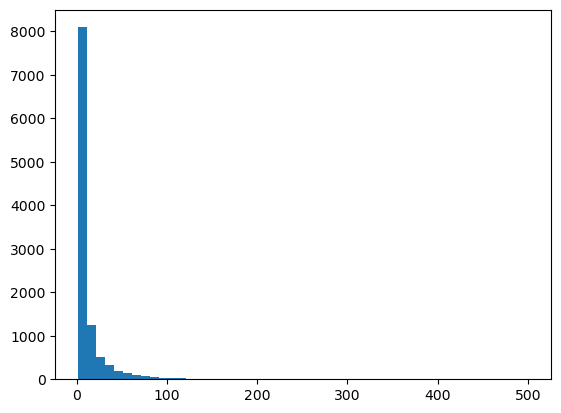

In [37]:
degree = [d for n, d in graph.degree()]
plt.hist(degree, bins = 50)

(array([8.091e+03, 1.252e+03, 5.090e+02, 3.340e+02, 1.930e+02, 1.410e+02,
        1.070e+02, 6.900e+01, 4.500e+01, 3.200e+01, 3.300e+01, 2.100e+01,
        1.700e+01, 6.000e+00, 1.400e+01, 6.000e+00, 6.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.,
        111., 121., 131., 141., 151., 161., 171., 181., 191., 201., 211.,
        221., 231., 241., 251., 261., 271., 281., 291., 301., 311., 321.,
        331., 341., 351., 361., 371., 381., 391., 401., 411., 421., 431.,
        441., 451., 461., 471., 481., 491., 501.]),
 <BarContainer object of 50 

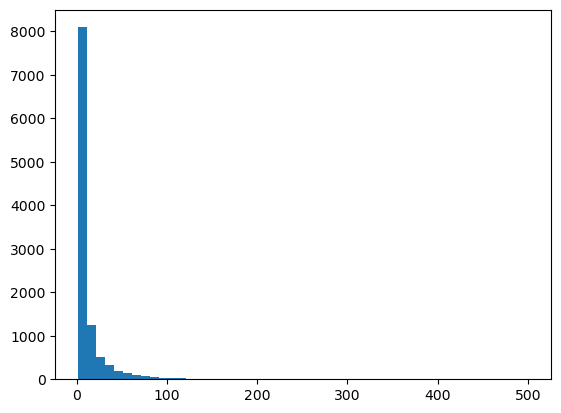

In [38]:
degree = [d for n, d in graph_rewired.degree()]
plt.hist(degree, bins = 50)

# Parallel simulation

Maybe we should make the calculations only on the largest component, because with rewiring there are a lot of disconnected components.


In [13]:
def parallel(graph, single, max_workers = 16, num_iterations = 100):
    """
    graph: graph or list of graphs if single = 0
    single: boolean, choose if running simulations on a single network (=1) or on several random realization of the networks (=0) 
    max_worker: number of cores, deafault to 16 because we run 2 simulations at the same time
    num_iterations = 100 number of total iterations for computing the error if > than len(graph) it runs multiple times on the same element of the list graph 
                        but if < len(graph) it runs only on the first num_iteration of them (not advised)
    """
    if(single==0):
        if not isinstance(graph, list):
            print("Graph is not a list of graphs. Exiting function.")
            return  # Exit the function if the conditions are not met
        extended_graph_rewired = [graph[i % len(graph)] for i in range(num_iterations)]  # line for simulation on rewired graphs
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Use tqdm to display a progress bar
        if(single==0):
            items = [(i, graph) for i, graph in zip(range(num_iterations), extended_graph_rewired)]
        else:
            items = [(i, graph) for i, graph in zip(range(num_iterations),  [graph for _ in range(num_iterations)])]
    
        list(executor.map(save_dataframe, items))
    gc.collect()

In [ ]:
parallel(graph, single = 1, num_iterations=100)

595982
595982
595982
595982
595982
595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])


595982


/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mg = pd.read_csv(mutation_map_filename, delim_whitespace=True, names = ['gene', 'mutations'])
/tmp/ipykernel_138151/1108817084.py:1134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Us

In [ ]:
'''
max_workers = 8
num_iterations = 100
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Use tqdm to display a progress bar
        #if(single==0):
          #  items = [(i, graph) for i, graph in zip(range(num_iterations), extended_graph_rewired)]
        #else:
        items = [(i, graph) for i, graph in zip(range(num_iterations),  [fully_connected_graph for _ in range(num_iterations)])]
    
        list(executor.map(save_dataframe, items))'
'''

38110815
38110815
38110815
38110815
38110815
38110815
38110815
38110815
Final P_inf =  0
Final P_inf =  0
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
38110815
Final P_inf =  0
38110815
38110815
Final P_inf =  0
38110815
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
Final P_inf =  0
38110815
Final P_inf =  0
38110815
38110815
38110815
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
38110815
Final P_inf =  0
38110815
38110815
Final P_inf =  0
Final P_inf =  0
Final P_inf =  0
Final P_inf =  0
38110815
38110815
38110815
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
38110815
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
38110815
Final P_inf =  0
38110815
Final P_inf =  0
38110815
38110815
Final P_inf =  0
38110815
Final P_inf =  0
Final P_inf =  0
38110815
38110815
Final P_inf =  0
Final P_inf =  0
38110815
3

In [ ]:

graph_rewired[10]
neig_deg = nx.average_neighbor_degree(graph_rewired[10])
ass = []
for i in np.arange(len(graph_rewired)):
    ass.append(nx.degree_assortativity_coefficient(graph_rewired[i]))

#plt.hist(neig_deg)

In [309]:
ass_rewired = nx.clustering(graph_rewired[0])
ass = nx.clustering(graph)


In [329]:
len(np.where(np.asarray(list(dict(ass_rewired).values())) == 0)[0])

5937

(array([6.432e+03, 3.070e+02, 3.850e+02, 3.860e+02, 3.430e+02, 2.900e+02,
        2.990e+02, 2.170e+02, 1.580e+02, 1.570e+02, 2.670e+02, 9.100e+01,
        7.500e+01, 1.120e+02, 8.400e+01, 3.500e+01, 2.240e+02, 4.300e+01,
        2.200e+01, 4.500e+01, 1.240e+02, 2.100e+01, 1.700e+01, 2.500e+01,
        1.200e+01, 1.600e+01, 2.900e+01, 1.300e+01, 1.100e+01, 9.000e+00,
        4.100e+01, 1.200e+01, 1.000e+01, 2.540e+02, 8.000e+00, 5.000e+00,
        8.000e+00, 5.000e+00, 9.000e+00, 4.000e+00, 2.100e+01, 6.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 8.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 3.400e+01, 2.000e+00, 2.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        5.000e+01, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

(array([6.082e+03, 6.290e+02, 9.110e+02, 6.930e+02, 3.480e+02, 2.120e+02,
        1.860e+02, 7.600e+01, 4.100e+01, 5.800e+01, 1.210e+02, 1.700e+01,
        5.000e+00, 3.500e+01, 1.700e+01, 0.000e+00, 7.400e+01, 3.000e+00,
        0.000e+00, 6.000e+00, 3.300e+01, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 6.900e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

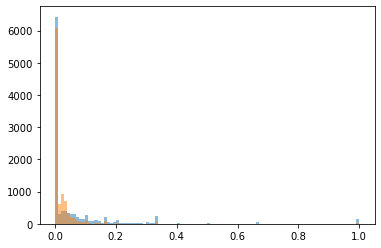

In [313]:
plt.hist(ass_rewired, bins = 100, alpha = 0.5)
plt.hist(list(dict(ass_rewired).values()), bins = 100, alpha = 0.5)
plt.savefig('plot_cc_distr_huri.png', dpi=300, bbox_inches='tight',transparent=True)

Text(0.5, 0, 'degree')

(0.0, 526.0)

(-0.1, 1.05)

Text(0, 0.5, 'Clustering coefficient')

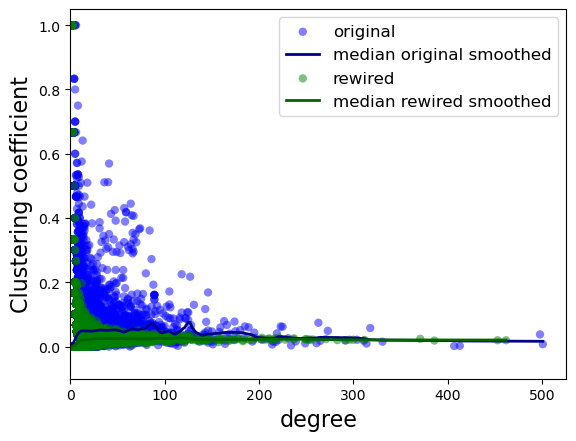

In [53]:
graph = nx.Graph(graph)
neig_deg = nx.clustering(graph)
df = nx.degree(graph)
plt.scatter(list(dict(df).values()), list(neig_deg.values()), c="b", edgecolors= 'None', alpha = 0.5, label = "original")
neig_deg2 = {}
for i in sorted(set(dict(df).values())):
    neig_deg2[i] = np.median([neig_deg[j] for j in dict(df).keys() if df[j] == i])
#plot the new dictionary
#plt.plot(list(neig_deg2.keys()), list(neig_deg2.values()), label = "median")  #not smoothed plot
#plt.plot(lowess(list(neig_deg2.values()), list(neig_deg2.keys()), frac=0.01)[:,1], "darkblue", lw = 2, label = "median original smoothed")
plt.plot(list(neig_deg2.keys()), gaussian_filter1d(list(neig_deg2.values()), sigma=3), "darkblue", lw = 2, label = "median original smoothed")

graph_rewired[0] = nx.Graph(graph_rewired[0])
neig_deg = nx.clustering(graph_rewired[0])
df = nx.degree(graph_rewired[0])
plt.scatter(list(dict(df).values()), list(neig_deg.values()), c ="g", edgecolors= 'None', alpha = 0.5,  label = "rewired")
neig_deg2 = {}
for i in sorted(set(dict(df).values())):
    neig_deg2[i] = np.median([neig_deg[j] for j in dict(df).keys() if df[j] == i])
#plot the new dictionary
#plt.plot(list(neig_deg2.keys()), list(neig_deg2.values()), label = "median")  #not smoothed plot
#plt.plot(lowess(list(neig_deg2.values()), list(neig_deg2.keys()), frac=0.01)[:,1], "darkgreen", lw = 2, label = "median rewired smoothed")
plt.plot(list(neig_deg2.keys()), gaussian_filter1d(list(neig_deg2.values()), sigma=3), "darkgreen", lw = 2, label = "median rewired smoothed")

#plt.plot(list(dict(df).values()), list(np.median(neig_deg.values())))
plt.xlabel("degree", fontsize=16)
plt.xlim(xmin=0)
plt.ylim(ymin=-0.1)
plt.ylabel("Clustering coefficient", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.savefig('plot_cc_huri.png', dpi=300, bbox_inches='tight',transparent=True)

<ipython-input-251-9d436701ed03>:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(list(dict(df).values())), np.log(list(neig_deg.values())), c="b", edgecolors= 'None', alpha = 0.5, label = "original", s = 0.1)


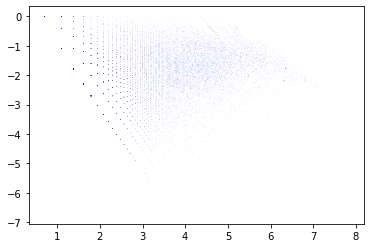

In [251]:
neig_deg = nx.clustering(graph)
df = nx.degree(graph)
plt.scatter(np.log(list(dict(df).values())), np.log(list(neig_deg.values())), c="b", edgecolors= 'None', alpha = 0.5, label = "original", s = 0.1)


<ipython-input-249-ab5efcbbbff2>:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(list(dict(df).values())), np.log(list(neig_deg.values())), c ="g", edgecolors= 'None', alpha = 0.5,  label = "rewired")


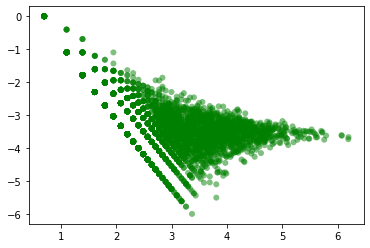

In [249]:
neig_deg = nx.clustering(graph_rewired[10])
df = nx.degree(graph_rewired[10])
plt.scatter(np.log(list(dict(df).values())), np.log(list(neig_deg.values())), c ="g", edgecolors= 'None', alpha = 0.5,  label = "rewired")


Text(0.5, 0, 'degree')

(0.0, 526.0)

(-0.1, 525.9875)

Text(0, 0.5, 'Average neighbors degree')

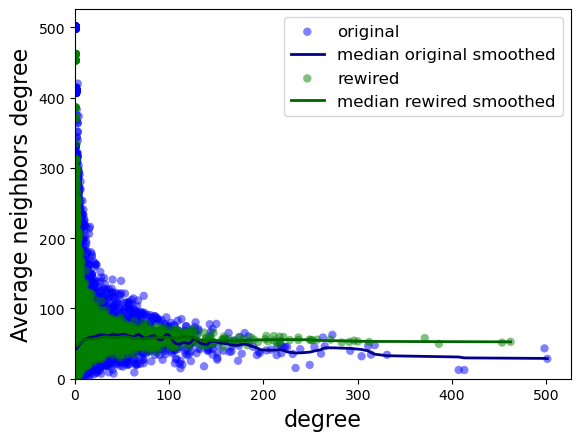

In [ ]:
#plot for figura 2 senza rewiring
neig_deg = nx.average_neighbor_degree(graph)
df = nx.degree(graph)
plt.scatter(list(dict(df).values()), list(neig_deg.values()), c="b", edgecolors= 'None', alpha = 0.5, label = "Average neighbors degree")
neig_deg2 = {}
for i in sorted(set(dict(df).values())):
    neig_deg2[i] = np.median([neig_deg[j] for j in dict(df).keys() if df[j] == i])
#plot the new dictionary
#plt.plot(list(neig_deg2.keys()), list(neig_deg2.values()), label = "median")  #not smoothed plot
#plt.plot(lowess(list(neig_deg2.values()), list(neig_deg2.keys()), frac=0.01)[:,1], "darkblue", lw = 2, label = "smoothed median")
plt.plot(list(neig_deg2.keys()), gaussian_filter1d(list(neig_deg2.values()), sigma=3), "darkblue", lw = 2, label = "smoothed median")
neig_deg = nx.clustering(graph)
#df = nx.degree(graph_rewired[0])
plt.scatter(list(dict(df).values()), list(neig_deg.values()), c ="g", edgecolors= 'None', alpha = 0.5,  label = "Clustering coefficient")
neig_deg2 = {}
for i in sorted(set(dict(df).values())):
    neig_deg2[i] = np.median([neig_deg[j] for j in dict(df).keys() if df[j] == i])
#plot the new dictionary
#plt.plot(list(neig_deg2.keys()), list(neig_deg2.values()), label = "median")  #not smoothed plot
#plt.plot(lowess(list(neig_deg2.values()), list(neig_deg2.keys()), frac=0.01)[:,1], "darkgreen", lw = 2, label = "median rewired smoothed")
plt.plot(list(neig_deg2.keys()), gaussian_filter1d(list(neig_deg2.values()), sigma=3), "darkgreen", lw = 2, label = "smoothed median")

#plt.plot(list(dict(df).values()), list(np.median(neig_deg.values())))
plt.xlabel("degree", fontsize=16)
plt.xlim(xmin=0)
plt.ylim(ymin=-0.1)
plt.ylabel("Average neighbors degree", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.savefig('plot_ave_neg_deg_huri.png', dpi=300, bbox_inches='tight',transparent=True)

NameError: name 'graph_rewired' is not defined

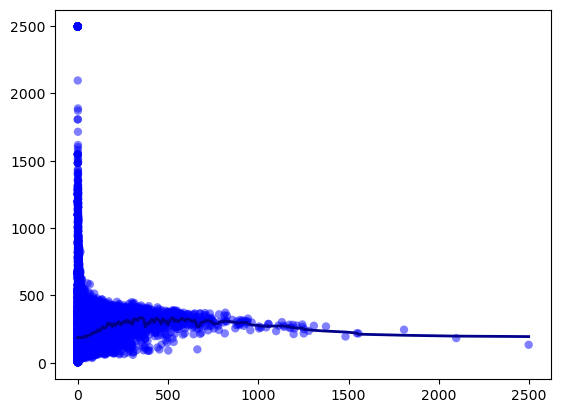

In [6]:
#plot figura 2 con rewiring
neig_deg = nx.average_neighbor_degree(graph)
df = nx.degree(graph)
plt.scatter(list(dict(df).values()), list(neig_deg.values()), c="b", edgecolors= 'None', alpha = 0.5, label = "original")
neig_deg2 = {}
for i in sorted(set(dict(df).values())):
    neig_deg2[i] = np.median([neig_deg[j] for j in dict(df).keys() if df[j] == i])
#plot the new dictionary
#plt.plot(list(neig_deg2.keys()), list(neig_deg2.values()), label = "median")  #not smoothed plot
#plt.plot(lowess(list(neig_deg2.values()), list(neig_deg2.keys()), frac=0.01)[:,1], "darkblue", lw = 2, label = "median original smoothed")
plt.plot(list(neig_deg2.keys()), gaussian_filter1d(list(neig_deg2.values()), sigma=3), "darkblue", lw = 2, label = "median original smoothed")
neig_deg = nx.average_neighbor_degree(graph_rewired[0])
df = nx.degree(graph_rewired[0])
plt.scatter(list(dict(df).values()), list(neig_deg.values()), c ="g", edgecolors= 'None', alpha = 0.5,  label = "rewired")
neig_deg2 = {}
for i in sorted(set(dict(df).values())):
    neig_deg2[i] = np.median([neig_deg[j] for j in dict(df).keys() if df[j] == i])
#plot the new dictionary
#plt.plot(list(neig_deg2.keys()), list(neig_deg2.values()), label = "median")  #not smoothed plot
#plt.plot(lowess(list(neig_deg2.values()), list(neig_deg2.keys()), frac=0.01)[:,1], "darkgreen", lw = 2, label = "median rewired smoothed")
plt.plot(list(neig_deg2.keys()), gaussian_filter1d(list(neig_deg2.values()), sigma=3), "darkgreen", lw = 2, label = "median rewired smoothed")

#plt.plot(list(dict(df).values()), list(np.median(neig_deg.values())))
plt.xlabel("degree", fontsize=16)
plt.xlim(xmin=0)
plt.ylim(ymin=-0.1)
plt.ylabel("Average neighbors degree", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.savefig('plot_ave_neg_deg_huri.png', dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
#Plot figure 2 panel C without rewiring

# Compute degrees and average neighbor degrees
degree_dict = dict(nx.degree(graph))
avg_neigh_deg = nx.average_neighbor_degree(graph)
clustering = nx.clustering(graph)

# Data
degrees = list(degree_dict.values())
y_neigh = [avg_neigh_deg[n] for n in degree_dict]
y_clust = [clustering[n] for n in degree_dict]

# Median values per degree
unique_degrees = sorted(set(degrees))
median_neigh_deg = {
    deg: np.median([avg_neigh_deg[n] for n in degree_dict if degree_dict[n] == deg])
    for deg in unique_degrees
}
median_clustering = {
    deg: np.median([clustering[n] for n in degree_dict if degree_dict[n] == deg])
    for deg in unique_degrees
}

# Smoothed curves
smooth_neigh = gaussian_filter1d(list(median_neigh_deg.values()), sigma=3)
smooth_clust = gaussian_filter1d(list(median_clustering.values()), sigma=3)

# Reversed x for clustering
reversed_degrees = list(reversed(unique_degrees))
reversed_clust = list(reversed(smooth_clust))

Text(0.5, 0, 'Node degree')

(0.0, 2621.8)

Text(0, 0.5, 'Clustering coefficient')

(2621.8, 0.0)

Text(0.5, 0, 'Node degree (reversed)')

Text(0, 0.5, 'Avg. neighbor degree')

(0.0, 2621.75)

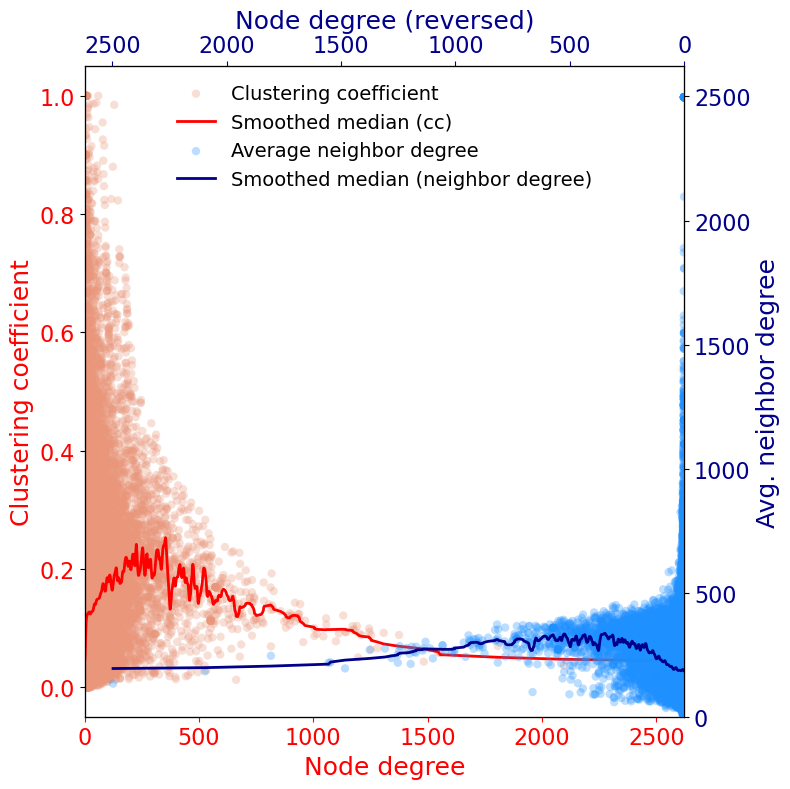

In [39]:


# Begin plot
fig, ax1 = plt.subplots(figsize=(8, 8))

# Left Y-axis: Average neighbor degree
ax1.scatter(degrees, y_clust, color='darksalmon', alpha=0.3, label='Clustering coefficient', edgecolors='none', zorder = 2)

ax1.set_xlabel("Node degree", fontsize=18, color='r')
ax1.tick_params(axis='y', labelcolor='r', labelsize=16)
ax1.set_xlim(left=0)
ax1.grid(False)
ax1.set_ylabel("Clustering coefficient", fontsize=18, color='r')
ax1.plot(
    unique_degrees[::-1], smooth_clust[::-1],
    color='red',
    linewidth=2,
    label='Smoothed median (cc)',
    zorder = 4
)
ax1.tick_params(axis='x', colors='r', labelsize=16)

ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim()[::-1])
ax_top.set_xlabel('Node degree (reversed)', color='darkblue', fontsize=18)
ax_top.tick_params(axis='x', colors='darkblue', labelsize=16)

# Right Y-axis: Clustering coefficient
ax2 = ax_top.twinx()
ax2.scatter(degrees, y_neigh, color='dodgerblue', alpha=0.3, label='Average neighbor degree', edgecolors='none', zorder = 1)
ax2.plot(
    unique_degrees, smooth_neigh,
    color='darkblue',
    linewidth=2,
    label='Smoothed median (neighbor degree)',
    zorder = 3
)
ax2.set_ylabel("Avg. neighbor degree", fontsize=18, color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=16)
ax2.set_ylim(bottom=0)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = plt.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=14)
legend.get_frame().set_linewidth(0)

# White background, no grid
fig.patch.set_facecolor('white')
#plt.title("Degree vs. Neighborhood Stats", fontsize=16)
plt.tight_layout()
plt.savefig("fig_2_panel_c.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


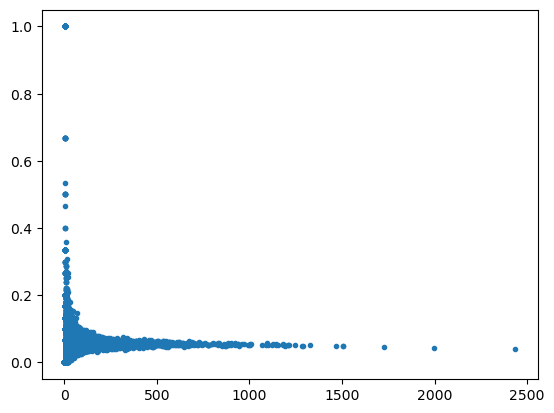

In [ ]:
neig_deg = nx.clustering(graph_rewired[10])
df = nx.degree(graph_rewired[10])
plt.plot(list(dict(df).values()), list(neig_deg.values()), ".")

The assortativity of the original interactome is significantly higher than the assortativity of the rewired interactomes. That could be the cause of the obserced resilience with high degree targetting. Indeed, positive assortativeness means that high degree nodes tend to link with high degree nodes

Plot of the clustering coefficient with respect to mutation frequency in pancancer 

Text(0.5, 0, 'Frequency of mutations')

(0.0, 0.05500000000000001)

Text(0, 0.5, 'Clustering coefficient')

(0.05500000000000001, 0.0)

Text(0.5, 0, 'Frequency of mutations (reversed)')

Text(0, 0.5, 'Degree')

(0.0, 0.05500000000000001)

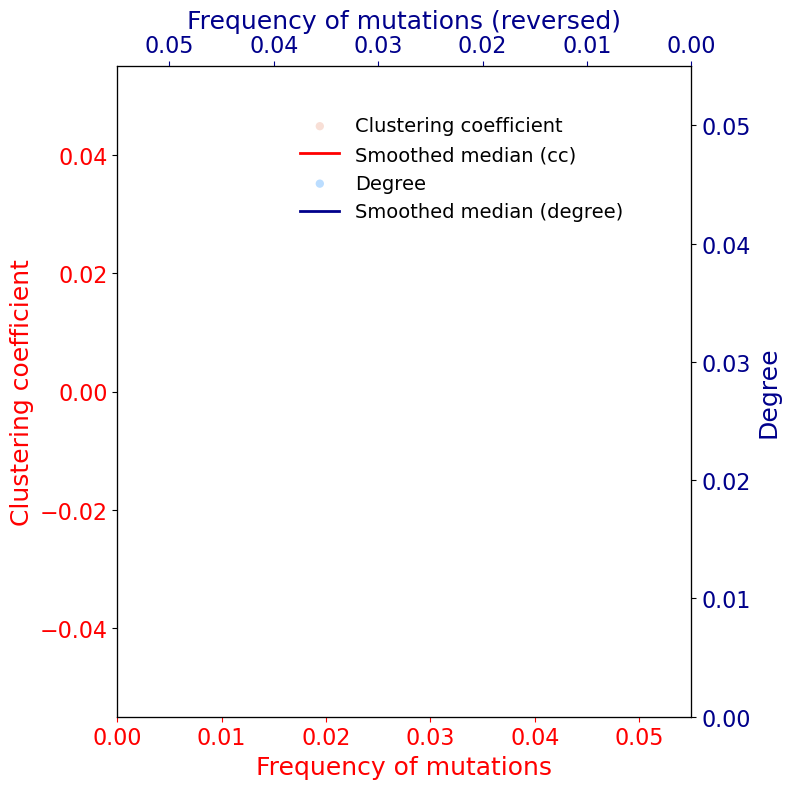

In [42]:
#Plot figure 3 panel B 

mg['mutations'] = mg['mutations'].astype('float64') 
mg_sorted= mg.sort_values(by='mutations')
neig_cc = nx.clustering(graph)
df_dict = pd.DataFrame(list(neig_cc.items()), columns=['gene', 'cc'])
merged_df = pd.merge(mg_sorted, df_dict, on='gene')
median_values = merged_df.groupby('mutations')['cc'].median()




# Begin plot
fig, ax1 = plt.subplots(figsize=(8, 8))

# Left Y-axis: Clustering coefficient
ax1.scatter(list(dict(merged_df['mutations']).values()), list(merged_df['cc']), color='darksalmon', alpha=0.3, label='Clustering coefficient', edgecolors='none', zorder = 2)

ax1.set_xlabel("Frequency of mutations", fontsize=18, color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=16)
ax1.set_xlim(left=0)
ax1.grid(False)
ax1.set_ylabel("Clustering coefficient", fontsize=18, color='red')
ax1.plot(
    list(median_values.keys()), gaussian_filter1d(list(median_values.values), sigma=3),
    color='red',
    linewidth=2,
    label='Smoothed median (cc)',
    zorder = 4
)
ax1.tick_params(axis='x', colors='red', labelsize=16)

ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim()[::-1])
ax_top.set_xlabel('Frequency of mutations (reversed)', color='darkblue', fontsize=18)
ax_top.tick_params(axis='x', colors='darkblue', labelsize=16)

df = nx.degree(graph)
df = dict(df)
df_dict = pd.DataFrame(list(df.items()), columns=['gene', 'degree'])
merged_df = pd.merge(mg_sorted, df_dict, on='gene')
median_values = merged_df.groupby('mutations')['degree'].median()

result = [x for x in list(merged_df['degree'])]


# Right Y-axis: degree
ax2 = ax_top.twinx()
ax2.scatter(list(dict(merged_df['mutations']).values()), result, color='dodgerblue', alpha=0.3, label='Degree', edgecolors='none', zorder = 1)
ax2.plot(
    list(median_values.keys()), gaussian_filter1d(list(median_values.values), sigma=3),
    color='darkblue',
    linewidth=2,
    label='Smoothed median (degree)',
    zorder = 3
)
ax2.set_ylabel("Degree", fontsize=18, color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=16)
ax2.set_ylim(bottom=0)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = plt.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.6, 0.95), fontsize=14)
legend.get_frame().set_linewidth(0)

# White background, no grid
fig.patch.set_facecolor('white')
plt.tight_layout()
#plt.savefig("fig_3_panel_B.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [29]:
mg['mutations'] = mg['mutations'].astype('float64') 
mg_sorted= mg.sort_values(by='mutations')
neig_deg = nx.clustering(graph)
df_dict = pd.DataFrame(list(neig_deg.items()), columns=['gene', 'cc'])
merged_df = pd.merge(mg_sorted, df_dict, on='gene')
median_values = merged_df.groupby('mutations')['cc'].median()


plt.scatter(list(dict(merged_df['mutations']).values()), list(merged_df['cc']), c="b", edgecolors= 'None', alpha = 0.5, label = "cc")

#plt.plot(list(dict(merged_df['mutations']).values()), list(merged_df['cc']), c="b", label = "mutated")
plt.plot(list(median_values.keys()), gaussian_filter1d(list(median_values.values), sigma=3), "darkblue", lw = 2, label = "median cc smoothed")



#neig_deg = nx.clustering(graph)
df = nx.degree(graph)
df = dict(df)
df_dict = pd.DataFrame(list(df.items()), columns=['gene', 'degree'])
merged_df = pd.merge(mg_sorted, df_dict, on='gene')
median_values = merged_df.groupby('mutations')['degree'].median()/max(list(merged_df['degree']))

result = [x / max(list(merged_df['degree'])) for x in list(merged_df['degree'])]

plt.scatter(list(dict(merged_df['mutations']).values()), result, c="g", edgecolors= 'None', alpha = 0.5, label = "normalized degree")

plt.plot(list(median_values.keys()), gaussian_filter1d(list(median_values.values), sigma=3), "darkgreen", lw = 2, label = "median normalized degree smoothed")

#plt.plot(list(dict(df).values()), list(np.median(neig_deg.values())))
plt.xlabel("N of mutations", fontsize=16)
plt.xlim(xmin=0)
plt.ylim(ymin=-0.01)
plt.xlim(xmin=-10)
#plt.ylabel("Clustering coefficient", fontsize=16)
#plt.xticks(range(0, 100 + 1, 10))
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.savefig('plot_cc_mutated_huri.png', dpi=300,transparent=True)



KeyboardInterrupt: 

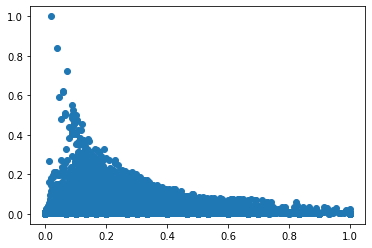

In [68]:
mg['mutations'] = mg['mutations'].astype('float64') 
mg_sorted= mg.sort_values(by='mutations')
neig_deg = nx.clustering(graph)
df_dict = pd.DataFrame(list(neig_deg.items()), columns=['gene', 'cc'])
merged_df = pd.merge(mg_sorted, df_dict, on='gene')
median_values = merged_df.groupby('mutations')['cc'].median()
plt.scatter( list(merged_df['cc']),result)

In [809]:
median_values = merged_df.groupby('mutations')['cc'].median()


In [7]:
nx.degree_assortativity_coefficient(graph)
nx.degree_assortativity_coefficient(graph_rewired[0])

0.056293523263389655

-0.008946586204557901

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Degree')

Text(0, 0.5, 'Probability Density')

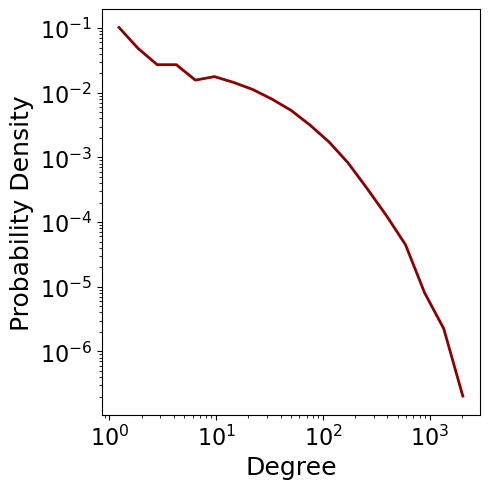

In [ ]:
#plot of degree distribution for plot 2 f
degree_sequence = [d for n, d in graph.degree()]
degree_array = np.array(degree_sequence)

# Define log-spaced bins
min_deg = max(1, degree_array.min())
max_deg = degree_array.max()
bins = np.logspace(np.log10(min_deg), np.log10(max_deg), num=20)

# Compute histogram (density=True for probability distribution)
counts, bin_edges = np.histogram(degree_array, bins=bins, density=True)

# Compute bin centers for plotting
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # geometric mean

# Plot the curve
plt.figure(figsize=(5, 5))
plt.plot(bin_centers, counts, linestyle='-',lw = 2, color='darkred', label='Degree Distribution')

plt.xlabel('Degree', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.gca().patch.set_facecolor('white')
plt.tight_layout()
plt.savefig("fig_2_panel_c_degree.png", dpi=300, bbox_inches="tight", transparent=True)
